In [1]:
import gurobipy as gp
import os
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import re

In [2]:
# get input paths
test_set = "miplib_5000_gurobi"
instance_fldr = os.path.join("instances", test_set)
test_set_fldr = os.path.join("test_sets", test_set)
results_fldr = os.path.join("results", test_set)
out_fldr = os.path.join("outputs", test_set)

# set filters
degrees = [-1, 1]
term_list = [4, 16, 64]
filter_cbc = False

## Check run failures

In [3]:
# running list of strings contained by different error codes
# last two are catchalls
err = {
    "walltime": [],
    "bad_alloc": [],
    "takeoffcuts": [],
    "solver is dual infeasible": [],
    "solver must be optimal": [],
    "segmentation fault": [],
    "no vpcs were made from a new disjunction": [],
    "farkas": [],
    "prlp is primal infeasible": [],  # put outstanding bugs below here
    "must have primalbound > root lp objective": [],
    "objective at parent node": [],
    "failed to optimize mip": [],
    "disjunction does not represent a full binary tree": [],
    "nonbasic reduced cost should be": [],
    "solver not proven optimal for node": [],
    "unable to open": [],
    "license": []
}

# read in cbc acceptable instances from cbc.txt
with open("cbc.txt", "r") as f:
    cbc_instances = f.read().split("\n")

# runs that errored out with new error code
other = []

# runs that had no errors
empty = []

# runs that only had warnings
warning = []

# series that didn't run
no_go = []

# track sizes of instances
rows, cols = {}, {}

# map the names
names = {}

# counts
count_series = 0
count_instances = 0

# iterate over all expected runs
for instance in os.listdir(test_set_fldr):
    if not os.path.isdir(os.path.join(test_set_fldr, instance)):
        continue
    # only look at cbc instances if we ran with cbc
    if instance not in cbc_instances and "gurobi" not in test_set and filter_cbc:
        continue
        
    # get the number of rows and columns in the instance
    mdl = gp.read(os.path.join(instance_fldr, f"{instance}.mps"))
    rows[instance] = mdl.NumConstrs
    cols[instance] = mdl.NumVars
        
    for perturbation in os.listdir(os.path.join(test_set_fldr, instance)):
        if not os.path.isdir(os.path.join(test_set_fldr, instance, perturbation)):
            continue
        # only look at perturbations that were run
        p, d = perturbation.split("_")
        if int(d) not in degrees:
            continue
        for terms in term_list:
            for generator in ["None", "New", "Old", "Farkas"]:

                # set variables for this iteration
                count_series += 1
                stem = f"{instance}_{perturbation}_{terms}_{generator}"
                file_pth = os.path.join(results_fldr, f"{stem}.err")
                series_fldr = os.path.join(test_set_fldr, instance, perturbation)
                count_instances += len([f for f in os.listdir(series_fldr) if
                                        f.endswith(".mps")])
                names[stem] = instance

                # check if the series wasn't run
                if not os.path.exists(file_pth):
                    no_go.append(stem)
                
                # check if the series ran with no errors or warnings
                elif os.path.getsize(file_pth) == 0:
                    empty.append(stem)
                
                # track which error codes were thrown
                else:
                    # read the file
                    with open(file_pth, "r") as f:
                        text = f.read().lower()
                    
                    # assign the error file to the appropriate list
                    found_code = False
                    for code in err:
                        if code in text:
                            err[code].append(stem)
                            found_code = True
                            break
                    if not found_code:
                        if "warning" in text:
                            warning.append(stem)
                        else:
                            other.append(stem)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-31
Read MPS format model from file instances/miplib_5000_gurobi/bienst2.mps
Reading time = 0.00 seconds
bienst2: 576 rows, 505 columns, 2184 nonzeros
Read MPS format model from file instances/miplib_5000_gurobi/set3-15.mps
Reading time = 0.00 seconds
set3-15: 3747 rows, 4019 columns, 13747 nonzeros
Read MPS format model from file instances/miplib_5000_gurobi/diamond.mps
Reading time = 0.00 seconds
DIAMOND: 4 rows, 2 columns, 8 nonzeros
Read MPS format model from file instances/miplib_5000_gurobi/f2gap801600.mps
Reading time = 0.00 seconds
f2gap801600: 80 rows, 1600 columns, 3200 nonzeros
Read MPS format model from file instances/miplib_5000_gurobi/neos-841664.mps
Reading time = 0.00 seconds
file: 3135 rows, 2925 columns, 10920 nonzeros
Read MPS format model from file instances/miplib_5000_gurobi/neos-3610173-itata.mps
Reading time = 0.00 seconds
neos-3610173-itata: 747 rows, 844 columns, 2130 nonzer

In [4]:
# check which series didn't run
print(no_go)

[]


In [5]:
# get the proportion of series that at least got started
1 - (len(no_go) / count_series)

1.0

In [6]:
# out of time - rerun with more time if a lot of these
print(err["walltime"])
len(err["walltime"]) / count_series

['neos-693347_rhs_1_64_New', 'neos-693347_rhs_1_64_Old', 'neos-693347_rhs_1_64_Farkas', 'neos-693347_objective_1_64_New', 'neos-693347_objective_1_64_Old', 'neos-693347_objective_1_64_Farkas', 'neos-693347_matrix_1_64_New', 'neos-693347_matrix_1_64_Old', 'neos-693347_matrix_1_64_Farkas', 'neos-693347_rhs_-1_64_Old', 'neos-693347_bound_1_64_New', 'neos-693347_bound_1_64_Farkas', 'cod105_rhs_1_16_Farkas', 'cod105_rhs_1_64_Farkas', 'cod105_objective_1_16_New', 'cod105_objective_1_16_Old', 'cod105_objective_1_16_Farkas', 'cod105_objective_1_64_New', 'cod105_objective_1_64_Old', 'cod105_objective_1_64_Farkas', 'cod105_matrix_1_16_New', 'cod105_matrix_1_16_Old', 'cod105_matrix_1_16_Farkas', 'cod105_matrix_1_64_New', 'cod105_matrix_1_64_Old', 'cod105_matrix_1_64_Farkas', 'cod105_matrix_-1_16_Old', 'cod105_matrix_-1_64_New', 'cod105_matrix_-1_64_Old', 'cod105_objective_-1_16_New', 'cod105_objective_-1_16_Farkas', 'cod105_objective_-1_64_New', 'cod105_objective_-1_64_Old', 'cod105_objective_-1_

0.002335575485799701

In [7]:
# out of memory - rerun with more memory if a lot of these
print(err["bad_alloc"])
len(err["bad_alloc"]) / count_series

['neos-3610173-itata_objective_1_64_Old', 'neos-3610173-itata_objective_1_64_Farkas', 'neos-3610051-istra_objective_1_64_Old', 'neos-3610051-istra_objective_1_64_Farkas', 'neos-585192_objective_1_16_Old', 'neos-585192_objective_1_16_Farkas', 'neos-585192_objective_1_64_New', 'neos-585192_objective_1_64_Old', 'neos-585192_objective_1_64_Farkas', 'neos-585192_objective_-1_16_Old', 'neos-585192_objective_-1_16_Farkas', 'neos-585192_objective_-1_64_Old', 'neos-585192_objective_-1_64_Farkas', 'neos-593853_objective_1_64_Old', 'neos-593853_objective_1_64_Farkas', 'neos-593853_matrix_-1_64_Farkas', 'neos-593853_objective_-1_64_Old', 'neos-593853_objective_-1_64_Farkas', 'macrophage_matrix_1_64_Farkas', 'macrophage_objective_-1_64_New', 'macrophage_objective_-1_64_Old', 'macrophage_objective_-1_64_Farkas', 'neos-503737_objective_1_64_New', 'neos-503737_objective_1_64_Old', 'neos-503737_objective_1_64_Farkas', 'neos-503737_matrix_1_64_New', 'neos-503737_matrix_1_64_Old', 'neos-503737_matrix_1_6

0.03634155455904335

In [8]:
# this is an issue with John's bookkeeping - not much we can do here
print(err["takeoffcuts"])
len(err["takeoffcuts"]) / count_series

[]


0.0

In [9]:
print(err["solver is dual infeasible"])
len(err["solver is dual infeasible"]) / count_series

[]


0.0

In [10]:
# these are usually issues with CLP finding optimality - not much we can do here
print(err["solver must be optimal"])
len(err["solver must be optimal"]) / count_series

['f2gap801600_bound_1_4_New', 'f2gap801600_bound_1_4_Old', 'f2gap801600_bound_1_4_Farkas', '10teams_bound_1_4_New', '10teams_bound_1_4_Old', '10teams_bound_1_4_Farkas', 'neos-585192_bound_1_16_New', 'neos-585192_bound_1_16_Old', 'neos-585192_bound_1_16_Farkas', 'neos-585192_bound_1_64_New', 'neos-585192_bound_1_64_Old', 'neos-585192_bound_1_64_Farkas', 'neos-892255_bound_1_4_New', 'neos-892255_bound_1_4_Old', 'neos-892255_bound_1_4_Farkas', 'neos-593853_bound_1_4_New', 'neos-593853_bound_1_4_Old', 'neos-593853_bound_1_4_Farkas', 'neos-593853_bound_1_16_New', 'neos-593853_bound_1_16_Old', 'neos-593853_bound_1_16_Farkas', 'neos-593853_bound_1_64_New', 'neos-593853_bound_1_64_Old', 'neos-593853_bound_1_64_Farkas', 'macrophage_bound_1_4_New', 'macrophage_bound_1_4_Old', 'macrophage_bound_1_4_Farkas', 'macrophage_bound_1_16_New', 'macrophage_bound_1_16_Old', 'macrophage_bound_1_16_Farkas', 'macrophage_bound_1_64_New', 'macrophage_bound_1_64_Old', 'macrophage_bound_1_64_Farkas', 'csched007_b

0.01868460388639761

In [11]:
print(err["segmentation fault"])
len(err["segmentation fault"]) / count_series

['f2gap801600_bound_1_4_None', 'f2gap801600_bound_1_16_None', 'f2gap801600_bound_1_64_None', '10teams_bound_1_4_None', '10teams_bound_1_16_None', '10teams_bound_1_64_None', 'neos-585192_objective_-1_64_New', 'neos-585192_bound_1_4_None', 'neos-585192_bound_1_16_None', 'neos-585192_bound_1_64_None', 'neos-892255_bound_1_4_None', 'neos-892255_bound_1_16_None', 'neos-892255_bound_1_64_None', 'neos-593853_bound_1_4_None', 'neos-593853_bound_1_16_None', 'neos-593853_bound_1_64_None', 'macrophage_bound_1_4_None', 'macrophage_bound_1_16_None', 'macrophage_bound_1_64_None', 'neos-503737_bound_1_4_None', 'neos-503737_bound_1_16_None', 'neos-503737_bound_1_64_None', 'csched007_bound_1_4_None', 'csched007_bound_1_16_None', 'csched007_bound_1_64_None', 'f2gap401600_bound_1_4_None', 'f2gap401600_bound_1_16_None', 'f2gap401600_bound_1_64_None', 'neos-933364_bound_1_4_None', 'neos-933364_bound_1_16_None', 'neos-933364_bound_1_64_None', 'p2756_bound_1_4_None', 'p2756_bound_1_16_None', 'p2756_bound_1_6

0.018310911808669655

In [12]:
# these should all be from the problem being too big and hitting the time limit or integer solutions
print(err["no vpcs were made from a new disjunction"])
missing_4_term = [n for n in err["no vpcs were made from a new disjunction"] if "_4_" in n]
missing_64_term = [n for n in err["no vpcs were made from a new disjunction"] if "_64_" in n]
missing_16_term = [n for n in err["no vpcs were made from a new disjunction"] if "_16_" in n]
print(f'4 term: {len(missing_4_term) / count_series}')
print(f'64 term: {len(missing_64_term) / count_series}')
print(f'16 term: {len(missing_16_term) / count_series}')

['bienst2_rhs_1_64_New', 'bienst2_rhs_1_64_Old', 'bienst2_rhs_1_64_Farkas', 'bienst2_objective_1_64_New', 'bienst2_objective_1_64_Old', 'bienst2_objective_1_64_Farkas', 'bienst2_matrix_-1_64_New', 'bienst2_matrix_-1_64_Old', 'bienst2_matrix_-1_64_Farkas', 'bienst2_objective_-1_64_New', 'bienst2_objective_-1_64_Old', 'bienst2_objective_-1_64_Farkas', 'f2gap801600_objective_1_64_New', 'f2gap801600_objective_1_64_Old', 'f2gap801600_objective_1_64_Farkas', 'f2gap801600_rhs_-1_64_New', 'f2gap801600_rhs_-1_64_Old', 'f2gap801600_rhs_-1_64_Farkas', 'f2gap801600_objective_-1_64_New', 'f2gap801600_objective_-1_64_Old', 'f2gap801600_objective_-1_64_Farkas', 'f2gap801600_bound_1_64_New', 'f2gap801600_bound_1_64_Old', 'f2gap801600_bound_1_64_Farkas', 'neos-841664_rhs_1_16_New', 'neos-841664_rhs_1_16_Old', 'neos-841664_rhs_1_16_Farkas', 'neos-841664_rhs_1_64_New', 'neos-841664_rhs_1_64_Old', 'neos-841664_rhs_1_64_Farkas', 'neos-841664_objective_1_16_New', 'neos-841664_objective_1_16_Old', 'neos-8416

In [13]:
vpc_err = {
    "CglVPC: Finishing with exit reason: PRLP_TIME_LIMIT": [],
    "CglVPC: Finishing with exit reason: TIME_LIMIT": [],
    "CglVPC: Finishing with exit reason: NO_CUTS_LIKELY": [],
    "CglVPC: Finishing with exit reason: PRLP_INFEASIBLE": [],
    "CglVPC: Finishing with exit reason: SUCCESS": [],
    "CglVPC: Finishing with exit reason: OPTIMAL_SOLUTION_FOUND": [],
    "CglVPC: Finishing with exit reason: FAIL_LIMIT": [],
    "CglVPC: Finishing with exit reason: NO_DISJUNCTION": [],
}

vpc_other = []

for stem in err["no vpcs were made from a new disjunction"]:
    file_pth = os.path.join(results_fldr, f"{stem}.out")

    with open(file_pth, "r") as f:
        text = f.read()
    
    # assign the error file to the appropriate list
    found_code = False
    for code in vpc_err:
        if code in text:
            vpc_err[code].append(stem)
            found_code = True
            break
    if not found_code:
        vpc_other.append(stem)

In [14]:
print(vpc_err["CglVPC: Finishing with exit reason: PRLP_TIME_LIMIT"])
len(vpc_err["CglVPC: Finishing with exit reason: PRLP_TIME_LIMIT"]) / len(err["no vpcs were made from a new disjunction"])

['bienst2_rhs_1_64_New', 'bienst2_rhs_1_64_Old', 'bienst2_rhs_1_64_Farkas', 'bienst2_objective_1_64_New', 'bienst2_objective_1_64_Old', 'bienst2_objective_1_64_Farkas', 'bienst2_matrix_-1_64_New', 'bienst2_matrix_-1_64_Old', 'bienst2_matrix_-1_64_Farkas', 'bienst2_objective_-1_64_New', 'bienst2_objective_-1_64_Old', 'bienst2_objective_-1_64_Farkas', 'f2gap801600_objective_1_64_New', 'f2gap801600_objective_1_64_Old', 'f2gap801600_objective_1_64_Farkas', 'f2gap801600_rhs_-1_64_New', 'f2gap801600_rhs_-1_64_Old', 'f2gap801600_rhs_-1_64_Farkas', 'f2gap801600_objective_-1_64_New', 'f2gap801600_objective_-1_64_Old', 'f2gap801600_objective_-1_64_Farkas', 'f2gap801600_bound_1_64_New', 'f2gap801600_bound_1_64_Old', 'f2gap801600_bound_1_64_Farkas', 'neos-841664_rhs_1_16_New', 'neos-841664_rhs_1_16_Old', 'neos-841664_rhs_1_16_Farkas', 'neos-841664_rhs_1_64_New', 'neos-841664_rhs_1_64_Old', 'neos-841664_rhs_1_64_Farkas', 'neos-841664_objective_1_16_New', 'neos-841664_objective_1_16_Old', 'neos-8416

0.40978753047718564

In [15]:
print(vpc_err["CglVPC: Finishing with exit reason: TIME_LIMIT"])
len(vpc_err["CglVPC: Finishing with exit reason: TIME_LIMIT"]) / len(err["no vpcs were made from a new disjunction"])

['neos-691058_rhs_1_64_New', 'neos-691058_rhs_1_64_Old', 'neos-691058_rhs_1_64_Farkas', 'neos-691058_objective_1_64_New', 'neos-691058_objective_1_64_Old', 'neos-691058_objective_1_64_Farkas', 'neos-691058_matrix_1_64_New', 'neos-691058_matrix_1_64_Old', 'neos-691058_matrix_1_64_Farkas', 'neos-691058_matrix_-1_64_New', 'neos-691058_matrix_-1_64_Old', 'neos-691058_matrix_-1_64_Farkas', 'neos-691058_objective_-1_64_New', 'neos-691058_objective_-1_64_Old', 'neos-691058_objective_-1_64_Farkas', 'neos-691058_bound_1_64_New', 'neos-691058_bound_1_64_Old', 'neos-691058_bound_1_64_Farkas', 'neos-691073_rhs_1_16_New', 'neos-691073_rhs_1_16_Old', 'neos-691073_rhs_1_16_Farkas', 'neos-691073_rhs_1_64_New', 'neos-691073_rhs_1_64_Old', 'neos-691073_rhs_1_64_Farkas', 'neos-691073_objective_1_16_New', 'neos-691073_objective_1_16_Old', 'neos-691073_objective_1_16_Farkas', 'neos-691073_objective_1_64_New', 'neos-691073_objective_1_64_Old', 'neos-691073_objective_1_64_Farkas', 'neos-691073_matrix_1_16_Ne

0.07262277951933124

In [16]:
print(vpc_err["CglVPC: Finishing with exit reason: NO_CUTS_LIKELY"])
len(vpc_err["CglVPC: Finishing with exit reason: NO_CUTS_LIKELY"]) / len(err["no vpcs were made from a new disjunction"])

['neos-555343_rhs_1_4_New', 'neos-555343_rhs_1_4_Old', 'neos-555343_rhs_1_4_Farkas', 'neos-555343_objective_1_4_New', 'neos-555343_objective_1_4_Old', 'neos-555343_objective_1_4_Farkas', 'neos-555343_matrix_1_4_New', 'neos-555343_matrix_1_4_Old', 'neos-555343_matrix_1_4_Farkas', 'neos-555343_bound_1_4_New', 'neos-555343_bound_1_4_Old', 'neos-555343_bound_1_4_Farkas', 'pigeon-20_rhs_1_4_New', 'pigeon-20_rhs_1_4_Old', 'pigeon-20_rhs_1_4_Farkas', 'pigeon-20_objective_1_4_New', 'pigeon-20_objective_1_4_Old', 'pigeon-20_objective_1_4_Farkas', 'pigeon-20_matrix_1_4_New', 'pigeon-20_matrix_1_4_Old', 'pigeon-20_matrix_1_4_Farkas', 'pigeon-20_rhs_-1_4_New', 'pigeon-20_rhs_-1_4_Old', 'pigeon-20_rhs_-1_4_Farkas', 'pigeon-20_bound_-1_4_New', 'pigeon-20_bound_-1_4_Old', 'pigeon-20_bound_-1_4_Farkas', 'pigeon-20_matrix_-1_4_New', 'pigeon-20_matrix_-1_4_Old', 'pigeon-20_matrix_-1_4_Farkas', 'pigeon-20_objective_-1_4_New', 'pigeon-20_objective_-1_4_Old', 'pigeon-20_objective_-1_4_Farkas', 'pigeon-20_b

0.3281086729362591

In [17]:
print(vpc_err["CglVPC: Finishing with exit reason: PRLP_INFEASIBLE"])
len(vpc_err["CglVPC: Finishing with exit reason: PRLP_INFEASIBLE"]) / len(err["no vpcs were made from a new disjunction"])

['neos-555343_rhs_1_16_New', 'neos-555343_rhs_1_16_Old', 'neos-555343_rhs_1_16_Farkas', 'neos-555343_objective_1_16_New', 'neos-555343_objective_1_16_Old', 'neos-555343_objective_1_16_Farkas', 'neos-555343_matrix_1_16_New', 'neos-555343_matrix_1_16_Old', 'neos-555343_matrix_1_16_Farkas', 'neos-555343_bound_1_16_New', 'neos-555343_bound_1_16_Old', 'neos-555343_bound_1_16_Farkas', 'neos-555343_bound_1_64_Old', 'pigeon-20_rhs_1_16_New', 'pigeon-20_rhs_1_16_Old', 'pigeon-20_rhs_1_16_Farkas', 'pigeon-20_rhs_1_64_New', 'pigeon-20_rhs_1_64_Old', 'pigeon-20_rhs_1_64_Farkas', 'pigeon-20_objective_1_16_New', 'pigeon-20_objective_1_16_Old', 'pigeon-20_objective_1_16_Farkas', 'pigeon-20_objective_1_64_New', 'pigeon-20_objective_1_64_Old', 'pigeon-20_objective_1_64_Farkas', 'pigeon-20_matrix_1_16_New', 'pigeon-20_matrix_1_16_Old', 'pigeon-20_matrix_1_16_Farkas', 'pigeon-20_matrix_1_64_New', 'pigeon-20_matrix_1_64_Old', 'pigeon-20_matrix_1_64_Farkas', 'pigeon-20_rhs_-1_16_New', 'pigeon-20_rhs_-1_16_

0.09212817833507489

In [18]:
print(vpc_err["CglVPC: Finishing with exit reason: SUCCESS"])
len(vpc_err["CglVPC: Finishing with exit reason: SUCCESS"]) / len(err["no vpcs were made from a new disjunction"])

['a1c1s1_rhs_1_16_New', 'a1c1s1_rhs_1_16_Old', 'a1c1s1_rhs_1_16_Farkas', 'a1c1s1_objective_1_16_New', 'a1c1s1_objective_1_16_Old', 'a1c1s1_objective_1_16_Farkas', 'a1c1s1_rhs_-1_16_New', 'a1c1s1_rhs_-1_16_Old', 'a1c1s1_rhs_-1_16_Farkas', 'a1c1s1_matrix_-1_16_New', 'a1c1s1_matrix_-1_16_Old', 'a1c1s1_matrix_-1_16_Farkas', 'a1c1s1_objective_-1_16_New', 'a1c1s1_objective_-1_16_Old', 'a1c1s1_objective_-1_16_Farkas', 'neos-1112787_rhs_1_4_New', 'neos-1112787_rhs_1_4_Old', 'neos-1112787_rhs_1_4_Farkas', 'neos-1112787_rhs_1_16_New', 'neos-1112787_rhs_1_16_Old', 'neos-1112787_rhs_1_16_Farkas', 'neos-1112787_objective_1_4_New', 'neos-1112787_objective_1_4_Old', 'neos-1112787_objective_1_4_Farkas', 'neos-1112787_objective_1_16_New', 'neos-1112787_objective_1_16_Farkas', 'neos-1112787_matrix_1_4_New', 'neos-1112787_matrix_1_4_Old', 'neos-1112787_matrix_1_4_Farkas', 'neos-1112787_matrix_1_16_New', 'neos-1112787_matrix_1_16_Old', 'neos-1112787_matrix_1_16_Farkas', 'neos-1112787_rhs_-1_4_New', 'neos-

0.020027864855451064

In [19]:
print(vpc_err["CglVPC: Finishing with exit reason: OPTIMAL_SOLUTION_FOUND"])
len(vpc_err["CglVPC: Finishing with exit reason: OPTIMAL_SOLUTION_FOUND"]) / len(err["no vpcs were made from a new disjunction"])

['rlp2_rhs_1_4_New', 'rlp2_rhs_1_4_Old', 'rlp2_rhs_1_4_Farkas', 'rlp2_rhs_1_16_New', 'rlp2_rhs_1_16_Old', 'rlp2_rhs_1_16_Farkas', 'rlp2_rhs_1_64_New', 'rlp2_rhs_1_64_Old', 'rlp2_rhs_1_64_Farkas', 'rlp2_objective_1_4_New', 'rlp2_objective_1_4_Old', 'rlp2_objective_1_4_Farkas', 'rlp2_objective_1_16_New', 'rlp2_objective_1_16_Old', 'rlp2_objective_1_16_Farkas', 'rlp2_objective_1_64_New', 'rlp2_objective_1_64_Old', 'rlp2_objective_1_64_Farkas', 'rlp2_matrix_1_4_New', 'rlp2_matrix_1_4_Old', 'rlp2_matrix_1_4_Farkas', 'rlp2_matrix_1_16_New', 'rlp2_matrix_1_16_Old', 'rlp2_matrix_1_16_Farkas', 'rlp2_matrix_1_64_New', 'rlp2_matrix_1_64_Old', 'rlp2_matrix_1_64_Farkas', 'rlp2_objective_-1_4_New', 'rlp2_objective_-1_4_Old', 'rlp2_objective_-1_4_Farkas', 'rlp2_objective_-1_16_New', 'rlp2_objective_-1_16_Old', 'rlp2_objective_-1_16_Farkas', 'rlp2_objective_-1_64_New', 'rlp2_objective_-1_64_Old', 'rlp2_objective_-1_64_Farkas', 'mod010_objective_1_16_New', 'mod010_objective_1_16_Old', 'mod010_objective

0.050156739811912224

In [20]:
print(vpc_err["CglVPC: Finishing with exit reason: FAIL_LIMIT"])
len(vpc_err["CglVPC: Finishing with exit reason: FAIL_LIMIT"]) / len(err["no vpcs were made from a new disjunction"])

['neos-1112787_objective_1_16_Old', 'neos-1112787_objective_-1_16_Farkas', 'neos-1112787_bound_1_16_Old', 'neos-3734794-moppy_objective_1_16_New', 'neos-3734794-moppy_objective_1_16_Old', 'neos-3734794-moppy_objective_1_16_Farkas', 'neos-3734794-moppy_matrix_1_16_New', 'neos-3734794-moppy_matrix_1_16_Old', 'neos-3734794-moppy_matrix_1_16_Farkas', 'neos-3734794-moppy_matrix_-1_16_New', 'neos-3734794-moppy_matrix_-1_16_Old', 'neos-3734794-moppy_matrix_-1_16_Farkas', 'neos-3734794-moppy_objective_-1_16_New', 'neos-3734794-moppy_objective_-1_16_Old', 'neos-3734794-moppy_objective_-1_16_Farkas', 'neos-3734794-moppy_bound_1_16_New', 'neos-3734794-moppy_bound_1_16_Old', 'neos-3734794-moppy_bound_1_16_Farkas', 'neos-1415183_matrix_-1_4_New', 'neos-1415183_matrix_-1_4_Old', 'neos-1415183_matrix_-1_4_Farkas', 'neos-1415183_bound_1_4_New', 'neos-1415183_bound_1_4_Old', 'neos-1415183_bound_1_4_Farkas', 'neos-1112782_rhs_1_64_New', 'neos-1112782_rhs_1_64_Old', 'neos-1112782_rhs_1_64_Farkas', 'neos-

0.009926854754440962

In [21]:
print(vpc_err["CglVPC: Finishing with exit reason: NO_DISJUNCTION"])
len(vpc_err["CglVPC: Finishing with exit reason: NO_DISJUNCTION"]) / len(err["no vpcs were made from a new disjunction"])

['neos-5192052-neckar_rhs_1_4_New', 'neos-5192052-neckar_rhs_1_4_Old', 'neos-5192052-neckar_rhs_1_4_Farkas', 'neos-5192052-neckar_rhs_1_16_New', 'neos-5192052-neckar_rhs_1_16_Old', 'neos-5192052-neckar_rhs_1_16_Farkas', 'neos-5192052-neckar_rhs_1_64_New', 'neos-5192052-neckar_rhs_1_64_Old', 'neos-5192052-neckar_rhs_1_64_Farkas', 'neos-5192052-neckar_objective_1_4_New', 'neos-5192052-neckar_objective_1_4_Old', 'neos-5192052-neckar_objective_1_4_Farkas', 'neos-5192052-neckar_objective_1_16_New', 'neos-5192052-neckar_objective_1_16_Old', 'neos-5192052-neckar_objective_1_16_Farkas', 'neos-5192052-neckar_objective_1_64_New', 'neos-5192052-neckar_objective_1_64_Old', 'neos-5192052-neckar_objective_1_64_Farkas', 'neos-5192052-neckar_matrix_1_4_New', 'neos-5192052-neckar_matrix_1_4_Old', 'neos-5192052-neckar_matrix_1_4_Farkas', 'neos-5192052-neckar_matrix_1_16_New', 'neos-5192052-neckar_matrix_1_16_Old', 'neos-5192052-neckar_matrix_1_16_Farkas', 'neos-5192052-neckar_matrix_1_64_New', 'neos-519

0.017241379310344827

In [22]:
vpc_other

[]

In [23]:
# get breakdown of why vpc generation failed - mostly from lack of provisioning
for code, exps in vpc_err.items():
    print(f"{code}: {len(exps) / len(err['no vpcs were made from a new disjunction'])}")

print(f"other: {len(vpc_other) / len(err['no vpcs were made from a new disjunction'])}")

CglVPC: Finishing with exit reason: PRLP_TIME_LIMIT: 0.40978753047718564
CglVPC: Finishing with exit reason: TIME_LIMIT: 0.07262277951933124
CglVPC: Finishing with exit reason: NO_CUTS_LIKELY: 0.3281086729362591
CglVPC: Finishing with exit reason: PRLP_INFEASIBLE: 0.09212817833507489
CglVPC: Finishing with exit reason: SUCCESS: 0.020027864855451064
CglVPC: Finishing with exit reason: OPTIMAL_SOLUTION_FOUND: 0.050156739811912224
CglVPC: Finishing with exit reason: FAIL_LIMIT: 0.009926854754440962
CglVPC: Finishing with exit reason: NO_DISJUNCTION: 0.017241379310344827
other: 0.0


In [24]:
# this may be a bug in my code - track down if a lot
print(err["farkas"])
len(err["farkas"]) / count_series

['bienst2_matrix_-1_4_New', 'f2gap801600_objective_1_16_New', 'f2gap801600_objective_1_16_Old', 'f2gap801600_objective_1_16_Farkas', 'f2gap801600_rhs_-1_16_New', 'f2gap801600_rhs_-1_16_Old', 'f2gap801600_rhs_-1_16_Farkas', 'f2gap801600_objective_-1_16_New', 'f2gap801600_objective_-1_16_Old', 'f2gap801600_objective_-1_16_Farkas', 'f2gap801600_bound_1_16_New', 'f2gap801600_bound_1_16_Old', 'f2gap801600_bound_1_16_Farkas', 'neos-3610173-itata_objective_1_16_New', '10teams_objective_1_4_New', '10teams_objective_-1_4_New', 'gmu-35-40_objective_1_4_New', 'gmu-35-40_objective_1_16_New', 'gmu-35-40_objective_1_64_New', 'gmu-35-40_objective_1_64_Old', 'gmu-35-40_objective_1_64_Farkas', 'gmu-35-40_matrix_-1_64_New', 'gmu-35-40_matrix_-1_64_Old', 'gmu-35-40_matrix_-1_64_Farkas', 'gmu-35-40_objective_-1_4_New', 'gmu-35-40_objective_-1_16_New', 'gmu-35-40_objective_-1_64_New', 'gmu-35-40_objective_-1_64_Old', 'gmu-35-40_objective_-1_64_Farkas', 'neos-585192_objective_1_4_New', 'neos-585192_objectiv

0.04460949177877429

In [25]:
# this shouldn't be an issue - effected runs just get skipped
print(err["prlp is primal infeasible"])
len(err["prlp is primal infeasible"]) / count_series

['f2gap801600_objective_1_4_Old', 'neos-841664_objective_1_4_Old', 'neos-841664_matrix_1_4_Old', 'neos-841664_objective_-1_4_Old', 'neos-3610173-itata_objective_1_4_Old', 'neos-3610173-itata_objective_1_16_Old', 'neos-3610173-itata_objective_-1_4_Old', 'neos-3610173-itata_objective_-1_64_Old', '10teams_objective_1_4_Old', 'gmu-35-40_objective_1_4_Old', 'gmu-35-40_objective_1_16_Old', 'gmu-35-40_matrix_-1_4_Old', 'gmu-35-40_matrix_-1_16_Old', 'gmu-35-40_objective_-1_4_Old', 'gmu-35-40_objective_-1_16_Old', 'neos-3610051-istra_objective_1_4_Old', 'neos-3610051-istra_rhs_-1_4_Old', 'neos-3610051-istra_matrix_-1_4_Old', 'neos-3610051-istra_matrix_-1_16_Old', 'neos-3610051-istra_objective_-1_16_New', 'neos-3610051-istra_objective_-1_64_New', 'neos-3610051-istra_objective_-1_64_Old', 'neos-593853_matrix_1_4_Old', 'neos-593853_matrix_1_16_Old', 'neos-593853_matrix_1_64_Old', 'neos-593853_matrix_-1_4_Old', 'neos-593853_matrix_-1_16_Old', 'neos-593853_matrix_-1_64_Old', 'macrophage_objective_1_

0.024336696562032883

In [26]:
print(warning)
len(warning) / count_series

['bienst2_rhs_1_16_Old', 'bienst2_objective_1_16_New', 'bienst2_objective_1_16_Old', 'bienst2_matrix_-1_16_New', 'bienst2_matrix_-1_16_Old', 'bienst2_objective_-1_16_New', 'bienst2_objective_-1_16_Old', 'neos-841664_rhs_1_4_New', 'neos-841664_matrix_1_4_New', 'neos-841664_rhs_-1_4_New', 'neos-841664_matrix_-1_4_New', 'neos-841664_matrix_-1_4_Old', '10teams_matrix_1_4_Old', '10teams_objective_-1_4_Old', 'gmu-35-40_matrix_-1_16_New', 'neos-892255_rhs_1_4_Old', 'neos-892255_objective_-1_4_Old', 'neos-912023_rhs_1_4_Old', 'neos-912023_objective_1_4_Old', 'neos-912023_objective_-1_4_Old', 'neos-593853_objective_1_4_New', 'neos-593853_objective_1_4_Old', 'neos-593853_objective_1_4_Farkas', 'neos-593853_objective_1_16_Old', 'neos-593853_objective_1_16_Farkas', 'neos-593853_matrix_1_4_New', 'neos-593853_matrix_1_4_Farkas', 'neos-593853_matrix_1_16_New', 'neos-593853_matrix_1_16_Farkas', 'neos-593853_matrix_1_64_New', 'neos-593853_matrix_1_64_Farkas', 'neos-593853_rhs_-1_4_New', 'neos-593853_rh

0.0226550822122571

In [27]:
# issue was not optimizing solver before checking LP relaxation objective vs primal bound
print(err["must have primalbound > root lp objective"])
len(err["must have primalbound > root lp objective"]) / count_series

['neos-1171737_matrix_1_4_None', 'neos-1171737_matrix_1_16_None', 'neos-1171737_matrix_1_64_None', 'neos-1171737_bound_1_4_None', 'neos-1171737_bound_1_16_None', 'neos-1171737_bound_1_64_None', 'neos-912015_objective_1_4_None', 'neos-912015_objective_1_16_None', 'neos-912015_objective_1_64_None', 'neos-912015_matrix_1_4_None', 'neos-912015_matrix_1_16_None', 'neos-912015_matrix_1_64_None', 'neos-912015_objective_-1_4_None', 'neos-912015_objective_-1_16_None', 'neos-912015_objective_-1_64_None', 'peg-solitaire-a3_rhs_1_4_None', 'peg-solitaire-a3_rhs_1_4_New', 'peg-solitaire-a3_rhs_1_4_Old', 'peg-solitaire-a3_rhs_1_4_Farkas', 'peg-solitaire-a3_rhs_1_16_None', 'peg-solitaire-a3_rhs_1_16_New', 'peg-solitaire-a3_rhs_1_16_Old', 'peg-solitaire-a3_rhs_1_16_Farkas', 'peg-solitaire-a3_rhs_1_64_None', 'peg-solitaire-a3_rhs_1_64_New', 'peg-solitaire-a3_rhs_1_64_Old', 'peg-solitaire-a3_rhs_1_64_Farkas', 'peg-solitaire-a3_objective_1_4_None', 'peg-solitaire-a3_objective_1_4_New', 'peg-solitaire-a3_o

0.020039237668161434

In [28]:
# LP relxation objective is not going to match root node objective when warm starting 
print(err["objective at parent node"])
len(err["objective at parent node"]) / count_series

[]


0.0

In [29]:
# not enough tolerance added to bound (or we hit time limit)
# todo handle this gracefully
print(err["failed to optimize mip"])
len(err["failed to optimize mip"]) / count_series

['neos-803219_matrix_1_16_Farkas', 'markshare_4_0_matrix_1_4_None', 'markshare_4_0_matrix_1_16_None', 'markshare_4_0_matrix_1_64_None']


0.0001868460388639761

In [30]:
# todo: figure out why
print(err["disjunction does not represent a full binary tree"])
len(err["disjunction does not represent a full binary tree"]) / count_series

['neos-3610173-itata_rhs_-1_16_New', 'neos-3610173-itata_rhs_-1_64_New', 'neos-3610173-itata_matrix_-1_16_New', 'neos-3610173-itata_matrix_-1_64_New', 'neos-3610051-istra_rhs_-1_64_New', 'neos-3610051-istra_matrix_-1_4_New', 'neos-3610051-istra_matrix_-1_16_New', 'neos-3610051-istra_matrix_-1_64_New', 'neos-3046601-motu_matrix_1_4_New', 'neos-3046601-motu_matrix_1_16_New', 'neos-3046601-motu_matrix_1_64_New', 'neos-3046601-motu_matrix_-1_16_New', 'neos-3046601-motu_matrix_-1_64_New', 'neos-574665_rhs_-1_64_New', 'neos-574665_matrix_-1_16_New', 'neos-574665_matrix_-1_64_New', 'csched007_matrix_-1_16_New', 'graphdraw-domain_rhs_1_16_New', 'graphdraw-domain_matrix_1_16_New', 'blend2_matrix_-1_16_New', 'blend2_matrix_-1_64_New', 'neos-3611447-jijia_rhs_1_64_New', 'neos-3611447-jijia_matrix_1_16_New', 'neos-3611447-jijia_matrix_1_64_New', 'neos-3611447-jijia_matrix_-1_16_New', 'neos-3611447-jijia_matrix_-1_64_New', 'neos-5051588-culgoa_matrix_1_16_New', 'neos-5051588-culgoa_matrix_-1_16_New

0.005605381165919282

In [31]:
# this and next issue I think are because we run out of time creating tree leading to errors
# todo: handle gracefully 
print(err["nonbasic reduced cost should be"])
len(err["nonbasic reduced cost should be"]) / count_series

['gmu-35-40_objective_1_4_Farkas', 'gmu-35-40_matrix_-1_4_New', 'gmu-35-40_matrix_-1_4_Farkas', 'gmu-35-40_objective_-1_4_Farkas', 'timtab1CUTS_objective_-1_64_Old', 'neos-1480121_objective_-1_4_New', 'bc1_rhs_1_4_New', 'bc1_rhs_1_4_Old', 'bc1_rhs_1_4_Farkas', 'bc1_rhs_1_16_New', 'bc1_rhs_1_16_Old', 'bc1_rhs_1_16_Farkas', 'bc1_rhs_1_64_New', 'bc1_rhs_1_64_Old', 'bc1_rhs_1_64_Farkas', 'bc1_objective_1_4_New', 'bc1_objective_1_4_Old', 'bc1_objective_1_4_Farkas', 'bc1_objective_1_16_New', 'bc1_objective_1_16_Old', 'bc1_objective_1_16_Farkas', 'bc1_objective_1_64_New', 'bc1_objective_1_64_Old', 'bc1_objective_1_64_Farkas', 'bc1_matrix_1_4_New', 'bc1_matrix_1_4_Old', 'bc1_matrix_1_4_Farkas', 'bc1_matrix_1_16_New', 'bc1_matrix_1_16_Old', 'bc1_matrix_1_16_Farkas', 'bc1_matrix_1_64_New', 'bc1_matrix_1_64_Old', 'bc1_matrix_1_64_Farkas', 'bc1_matrix_-1_4_New', 'bc1_matrix_-1_4_Old', 'bc1_matrix_-1_4_Farkas', 'bc1_matrix_-1_16_New', 'bc1_matrix_-1_16_Old', 'bc1_matrix_-1_16_Farkas', 'bc1_matrix_-

0.007660687593423019

In [32]:
# again issue with not getting through vpc generation in time
# todo: handle this gracefully
print(err["solver not proven optimal for node"])
len(err["solver not proven optimal for node"]) / count_series

['neos-848845_rhs_1_16_New', 'neos-848845_rhs_1_16_Old', 'neos-848845_rhs_1_16_Farkas', 'neos-848845_rhs_1_64_New', 'neos-848845_rhs_1_64_Old', 'neos-848845_rhs_1_64_Farkas', 'neos-848845_matrix_1_16_New', 'neos-848845_matrix_1_16_Old', 'neos-848845_matrix_1_16_Farkas', 'neos-848845_matrix_1_64_New', 'neos-848845_matrix_1_64_Old', 'neos-848845_matrix_1_64_Farkas', 'neos-848845_matrix_-1_16_New', 'neos-848845_matrix_-1_16_Old', 'neos-848845_matrix_-1_16_Farkas', 'neos-848845_matrix_-1_64_New', 'neos-848845_matrix_-1_64_Old', 'neos-848845_matrix_-1_64_Farkas', 'neos-848845_bound_1_16_New', 'neos-848845_bound_1_16_Old', 'neos-848845_bound_1_16_Farkas', 'neos-848845_bound_1_64_New', 'neos-848845_bound_1_64_Old', 'neos-848845_bound_1_64_Farkas', 'neos-849702_rhs_1_16_New', 'neos-849702_rhs_1_16_Old', 'neos-849702_rhs_1_16_Farkas', 'neos-849702_rhs_1_64_New', 'neos-849702_rhs_1_64_Old', 'neos-849702_rhs_1_64_Farkas', 'neos-849702_matrix_1_16_Farkas', 'neos-849702_matrix_1_64_New', 'neos-8497

0.002102017937219731

In [33]:
print(err["unable to open"])
len(err["unable to open"]) / count_series

['mas74_rhs_1_16_Old', 'mas74_objective_1_4_Farkas', 'mas74_objective_1_64_None', 'mas74_matrix_-1_16_New', 'mas74_matrix_-1_16_Old', 'prod2_matrix_1_4_Farkas', 'ns1606230_objective_-1_16_None', 'mc11_rhs_-1_64_Farkas', '50v-10_objective_1_4_Farkas', '50v-10_objective_1_16_None', '50v-10_matrix_1_64_None']


0.0005138266068759343

In [34]:
print(err["license"])
len(err["license"]) / count_series

[]


0.0

In [35]:
# errors unaccounted for
print(other)
len(other) / count_series

['gmu-35-40_objective_-1_16_Farkas', 'neos-803220_rhs_-1_64_New', 'neos-1480121_objective_1_64_New', 'neos-1480121_objective_-1_16_New', 'neos-803219_objective_1_64_New', 'neos-803219_objective_1_64_Old', 'neos-803219_objective_1_64_Farkas', 'neos-803219_matrix_1_16_New', 'neos-803219_matrix_1_64_New', 'neos-803219_matrix_1_64_Old', 'neos-803219_matrix_1_64_Farkas', 'neos-803219_rhs_-1_64_New', 'neos-803219_rhs_-1_64_Old', 'neos-803219_rhs_-1_64_Farkas', 'neos-803219_matrix_-1_64_New', 'neos-803219_matrix_-1_64_Old', 'neos-803219_matrix_-1_64_Farkas', 'neos-803219_objective_-1_64_New', 'neos-803219_objective_-1_64_Old', 'neos-803219_objective_-1_64_Farkas', 'neos-1396125_objective_1_4_New', 'bppc8-09_objective_-1_16_Farkas', 'irp_objective_1_64_New', 'irp_objective_1_64_Old', 'irp_objective_1_64_Farkas', 'irp_matrix_1_64_New', 'irp_matrix_1_64_Old', 'irp_matrix_1_64_Farkas', 'irp_bound_-1_64_New', 'irp_bound_-1_64_Old', 'irp_bound_-1_64_Farkas', 'irp_matrix_-1_64_New', 'irp_matrix_-1_6

0.005371823617339312

In [36]:
# proportion of series that were improperly provisioned
(len(err["bad_alloc"] + err["walltime"])) / count_series

0.03867713004484305

In [37]:
# get breakdown of errors
for code, exps in err.items():
    print(f"{code}: {len(exps) / count_series}")

print(f"other: {len(other) / count_series}")

print(f"warning: {len(warning) / count_series}")

print(f"no errors/warnings: {len(empty) / count_series}")

walltime: 0.002335575485799701
bad_alloc: 0.03634155455904335
takeoffcuts: 0.0
solver is dual infeasible: 0.0
solver must be optimal: 0.01868460388639761
segmentation fault: 0.018310911808669655
no vpcs were made from a new disjunction: 0.2682174887892377
farkas: 0.04460949177877429
prlp is primal infeasible: 0.024336696562032883
must have primalbound > root lp objective: 0.020039237668161434
objective at parent node: 0.0
failed to optimize mip: 0.0001868460388639761
disjunction does not represent a full binary tree: 0.005605381165919282
nonbasic reduced cost should be: 0.007660687593423019
solver not proven optimal for node: 0.002102017937219731
unable to open: 0.0005138266068759343
license: 0.0
other: 0.005371823617339312
no errors/warnings: 0.5230287742899851


## Read in data

In [38]:
# map generator names to the corresponding data frames
df_map = {
    "None": pd.DataFrame(),
    "Farkas": pd.DataFrame(),
    "New": pd.DataFrame(),
    "Old": pd.DataFrame()
}
gap_map = {
    "None": pd.DataFrame(),
    "Farkas": pd.DataFrame(),
    "New": pd.DataFrame(),
    "Old": pd.DataFrame()
}
regex = re.compile(r'([a-zA-Z0-9-]+(?:_o)?)_([a-z]+)_([0-9-]+)_([0-9]+)_([a-zA-Z ]+)')

# declaring types as needed
column_types = {
    "lpBound": float,
    "lpBoundPostVpc": float,
    "disjunctiveDualBound": float,
    "primalBound": float,
    "rootDualBound": float,
    "dualBound": float
}

# iterate over all files in the folder
for file_name in os.listdir(results_fldr):
    
    file_pth = os.path.join(results_fldr, file_name)
    
    # if the file is not a nonempty csv, skip it
    if not file_name.endswith(".csv") or os.path.getsize(file_pth) == 0:
        continue
    
    # get the experimental set up
    match = regex.search(file_name)
    instance_name = match.group(1)
    perturbation = match.group(2)
    degree = 2**int(match.group(3))
    terms = int(match.group(4))
    generator = match.group(5)
    
    # read the file
    df = pd.read_csv(file_pth, keep_default_na=False, dtype=column_types)
    
    # add some identifying columns
    df["instance"] = instance_name
    df["perturbation"] = perturbation
    df["degree"] = degree
    df["terms"] = terms
    
    # append to the appropriate data frame
    df_map[generator] = pd.concat([df_map[generator], df])

In [39]:
# get proportion of instances run
for generator, df in df_map.items():
    print(f"{generator}: {4 * len(df) / count_instances}")

None: 0.9300696695354123
Farkas: 0.5095190194106032
New: 0.472076301181029
Old: 0.4569129317089527


In [40]:
gen = "Farkas" # make sure masks 3 and 9 are fixed rest should be fine
masks = {
        0: -1e20 > df_map[gen]["lpBound"],
        1: df_map[gen]["lpBound"] - 1e-4 > df_map[gen]["lpBoundPostVpc"],
        2: df_map[gen]["lpBoundPostVpc"] - 1e-4 > df_map[gen]["disjunctiveDualBound"],
        3: df_map[gen]["lpBoundPostVpc"] - 1e-4 > df_map[gen]["rootDualBound"],
        4: df_map[gen]["rootDualBound"] - 1e-4 > df_map[gen]["dualBound"],
        5: df_map[gen]["dualBound"] - 1e-4 > df_map[gen]["primalBound"],
        6: df_map[gen]["primalBound"] > 1e20,
        7: 0 > df_map[gen]["vpcGenerationTime"],
        8: df_map[gen]["vpcGenerationTime"] - 1e-4 > df_map[gen]["rootDualBoundTime"],
        9: df_map[gen]["rootDualBoundTime"] - 1e-4 > df_map[gen]["terminationTime"],
        10: df_map[gen]["vpcGenerationTime"] - 1e-4 > df_map[gen]["bestSolutionTime"],
        11: df_map[gen]["bestSolutionTime"] - 1e-4 > df_map[gen]["terminationTime"],
        12: df_map[gen]["terminationTime"] > df_map[gen]["maxTime"] + 20
    }

df_map[gen][masks[0]]

,instanceIndex,vpcGenerator,terms,lpBound,disjunctiveDualBound,lpBoundPostVpc,rootDualBound,dualBound,primalBound,vpcGenerationTime,...,iterations,maxTime,actualTerms,numCuts,cutLimit,mipSolver,providePrimalBound,instance,perturbation,degree


In [41]:
for gen in df_map:
    mask = (-1e20 > df_map[gen]["lpBound"]) | \
        (df_map[gen]["lpBound"] - 1e-4 > df_map[gen]["lpBoundPostVpc"]) | \
        (df_map[gen]["lpBoundPostVpc"] - 1e-4 > df_map[gen]["disjunctiveDualBound"]) | \
        (df_map[gen]["lpBoundPostVpc"] - 1e-4 > df_map[gen]["rootDualBound"]) | \
        (df_map[gen]["rootDualBound"] - 1e-4 > df_map[gen]["dualBound"]) | \
        (df_map[gen]["dualBound"] - 1e-4 > df_map[gen]["primalBound"]) | \
        (df_map[gen]["primalBound"] > 1e20) | \
        (0 > df_map[gen]["vpcGenerationTime"]) | \
        (df_map[gen]["vpcGenerationTime"] - 1e-4 > df_map[gen]["rootDualBoundTime"]) | \
        (df_map[gen]["rootDualBoundTime"] - 1e-4 > df_map[gen]["terminationTime"]) | \
        (df_map[gen]["vpcGenerationTime"] - 1e-4 > df_map[gen]["bestSolutionTime"]) | \
        (df_map[gen]["bestSolutionTime"] - 1e-4 > df_map[gen]["terminationTime"]) | \
        (df_map[gen]["terminationTime"] > df_map[gen]["maxTime"] + 20)
    df_map[gen] = df_map[gen][~mask]

In [42]:
# merge the 4 different data frames into one
join_cols = ["instance", "perturbation", "degree", "terms", "instanceIndex"]
df = df_map["None"].merge(df_map["New"], on=join_cols,
                                suffixes=(" None", None))
df = df.merge(df_map["Old"], on=join_cols,
                          suffixes=(" New", None))
df = df.merge(df_map["Farkas"], on=join_cols,
                          suffixes=(" Old", " Farkas"))
df

,instanceIndex,vpcGenerator None,terms,lpBound None,disjunctiveDualBound None,lpBoundPostVpc None,rootDualBound None,dualBound None,primalBound None,vpcGenerationTime None,...,bestSolutionTime Farkas,terminationTime Farkas,nodes Farkas,iterations Farkas,maxTime Farkas,actualTerms Farkas,numCuts Farkas,cutLimit Farkas,mipSolver Farkas,providePrimalBound Farkas
0,0,None,4,39794.745138,39794.745138,39794.745138,52012.519535,52148.000000,52148.000000,0.000004,...,81.359286,81.365648,15,1055,3600.0,4,120,125,GUROBI,1
1,0,None,16,197818.254988,197818.254988,197818.254988,389833.684790,405935.180000,405935.180000,0.000003,...,23.055134,23.080953,379,2434,3600.0,20,15,38,GUROBI,1
2,1,None,16,197417.068309,197417.068309,197417.068309,388301.647501,405935.180000,405935.180000,0.000003,...,1.576733,1.591326,448,3424,3600.0,20,15,0,GUROBI,1
3,2,None,16,198953.454988,198953.454988,198953.454988,401290.190660,405935.180000,405935.180000,0.000007,...,1.193952,1.205014,111,1252,3600.0,20,15,0,GUROBI,1
4,3,None,16,210037.457216,210037.457216,210037.457216,386773.032430,407941.580000,407941.580000,0.000003,...,1.302939,1.364412,370,2682,3600.0,20,15,0,GUROBI,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10399,1,None,16,0.010856,0.010856,0.010856,0.039218,0.321228,0.321228,0.000003,...,17.531035,97.909290,39791,972251,3600.0,16,31,0,GUROBI,1
10400,2,None,16,0.010572,0.010572,0.010572,0.025866,0.178185,0.178198,0.000003,...,2.155525,8.425301,5297,80813,3600.0,16,31,0,GUROBI,1
10401,3,None,16,0.009762,0.009762,0.009762,0.036309,0.252931,0.252948,0.000003,...,3.356710,116.149769,36727,1003297,3600.0,16,31,0,GUROBI,1
10402,4,None,16,0.011922,0.011922,0.011922,0.044839,0.329957,0.329987,0.000003,...,386.232944,386.233102,118850,3270208,3600.0,16,31,0,GUROBI,1


In [43]:
# get proportion of tests run to completion
4 * len(df) / count_instances

0.38761596065720355

In [44]:
def gap_closed(df, col):
    gap = abs(df[col] - df["lpBound None"]) / abs(df['primalBound None'] - df["lpBound None"])
    gap[(gap < 0) | (gap > 1)] = np.nan
    return gap

In [45]:
# find the optimality gap closed by each generator
df["Disjunction (New)"] = gap_closed(df, "disjunctiveDualBound New")
df["Disjunction (Old)"] = gap_closed(df, "disjunctiveDualBound Old")
df["VPCs (New)"] = gap_closed(df, "lpBoundPostVpc New")
df["VPCs (Old)"] = gap_closed(df, "lpBoundPostVpc Old")
df["VPCs (Farkas)"] = gap_closed(df, "lpBoundPostVpc Farkas")
df["Root Cuts (None)"] = gap_closed(df, "rootDualBound None")
df["Root Cuts (New)"] = gap_closed(df, "rootDualBound New")
df["Root Cuts (Old)"] = gap_closed(df, "rootDualBound Old")
df["Root Cuts (Farkas)"] = gap_closed(df, "rootDualBound Farkas")
df["Root Optimality Gap Improvement"] = (df["Root Cuts (Farkas)"] - df["Root Cuts (None)"]) / df["Root Cuts (None)"] 
df = df.dropna()

In [46]:
# find times without vpc generation
df["terminationTimeSansVpc None"] = df["terminationTime None"]
df["terminationTimeSansVpc New"] = df["terminationTime New"] - df["vpcGenerationTime New"]
df["terminationTimeSansVpc Old"] = df["terminationTime Old"] - df["vpcGenerationTime Old"]
df["terminationTimeSansVpc Farkas"] = df["terminationTime Farkas"] - df["vpcGenerationTime Farkas"]
df["rootDualBoundTimeSansVpc None"] = df["rootDualBoundTime None"]
df["rootDualBoundTimeSansVpc New"] = df["rootDualBoundTime New"] - df["vpcGenerationTime New"]
df["rootDualBoundTimeSansVpc Old"] = df["rootDualBoundTime Old"] - df["vpcGenerationTime Old"]
df["rootDualBoundTimeSansVpc Farkas"] = df["rootDualBoundTime Farkas"] - df["vpcGenerationTime Farkas"]
df["postRootTime None"] = df["terminationTime None"] - df["rootDualBoundTime None"]
df["postRootTime New"] = df["terminationTime New"] - df["rootDualBoundTime New"]
df["postRootTime Old"] = df["terminationTime Old"] - df["rootDualBoundTime Old"]
df["postRootTime Farkas"] = df["terminationTime Farkas"] - df["rootDualBoundTime Farkas"]
df["terminationTimeImprovement"] = (df["terminationTime None"] - df["terminationTime Farkas"]) / df["terminationTime None"]
df["nodeImprovement"] = (df["nodes None"] - df["nodes Farkas"]) / df["nodes None"] 
df["iterationImprovement"] = (df["iterations None"] - df["iterations Farkas"]) / df["iterations None"] 

/var/folders/pb/p1sshdnx5sv12zwsxff8nrg40000gn/T/ipykernel_5163/2524607786.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["terminationTimeSansVpc None"] = df["terminationTime None"]
/var/folders/pb/p1sshdnx5sv12zwsxff8nrg40000gn/T/ipykernel_5163/2524607786.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["terminationTimeSansVpc New"] = df["terminationTime New"] - df["vpcGenerationTime New"]
/var/folders/pb/p1sshdnx5sv12zwsxff8nrg40000gn/T/ipykernel_5163/2524607786.py:4: SettingWithCopyWarning:

In [47]:
def optimality_gap(df, generator=None):
    if generator:
        return abs(df[f"primalBound {generator}"] - df[f"dualBound {generator}"]) / \
            abs(df[f"primalBound {generator}"])
    else:
        return abs(df[f"primalBound"] - df[f"dualBound"]) / abs(df[f"primalBound"])

In [48]:
# get rid of instances that solved trivially quickly
mean_run = df_map["None"].loc[(df_map["None"]["instanceIndex"] == 0) &
                              (optimality_gap(df_map["None"]) <= 1e-4)].groupby("instance")["terminationTime"].mean().to_dict()
toss = [instance for instance, time in mean_run.items() if time < 1]
df = df.loc[~df["instance"].isin(toss)]

In [49]:
df

,instanceIndex,vpcGenerator None,terms,lpBound None,disjunctiveDualBound None,lpBoundPostVpc None,rootDualBound None,dualBound None,primalBound None,vpcGenerationTime None,...,rootDualBoundTimeSansVpc New,rootDualBoundTimeSansVpc Old,rootDualBoundTimeSansVpc Farkas,postRootTime None,postRootTime New,postRootTime Old,postRootTime Farkas,terminationTimeImprovement,nodeImprovement,iterationImprovement
7,0,None,16,6.519542e+06,6.519542e+06,6.519542e+06,1.148617e+07,1.149067e+07,1.149067e+07,0.000003,...,0.752263,0.758677,0.879708,27.603801,5.173726,5.705293,5.484485,-0.035336,0.943226,0.781125
8,1,None,16,9.067934e+05,9.067934e+05,9.067934e+05,9.106540e+06,9.135598e+06,9.135926e+06,0.000003,...,0.531730,0.537845,0.668578,28.238741,32.148449,33.349645,34.894502,-0.466115,0.162301,-0.096603
9,0,None,4,-1.216923e+06,-1.216923e+06,-1.216923e+06,-5.912043e+05,-5.031598e+04,1.321565e+04,0.000002,...,0.434749,0.436960,0.436368,3599.570921,3599.566074,3599.563870,3599.564464,-0.001727,-0.110929,0.026481
10,1,None,4,-5.924022e+05,-5.924022e+05,-5.924022e+05,-1.042603e+05,-1.031375e+05,-1.031287e+05,0.000003,...,0.332280,0.436018,0.347002,0.227246,0.356746,0.169076,0.169288,-0.529030,0.237500,0.207214
11,0,None,4,2.654737e+03,2.654737e+03,2.654737e+03,2.685080e+03,2.713000e+03,2.713000e+03,0.000004,...,2.190975,2.180550,2.313906,6.226537,34.315753,34.530985,34.842583,-80.028913,-2.228302,-2.691790
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10399,1,None,16,1.085600e-02,1.085600e-02,1.085600e-02,3.921800e-02,3.212280e-01,3.212280e-01,0.000003,...,0.175697,0.209842,0.167411,65.093324,225.266261,59.700633,96.976673,-0.499740,-0.887260,-0.745557
10400,2,None,16,1.057200e-02,1.057200e-02,1.057200e-02,2.586600e-02,1.781850e-01,1.781980e-01,0.000003,...,0.172782,0.246196,0.221854,12.053965,16.711920,9.545135,7.368141,0.311664,0.390799,0.430188
10401,3,None,16,9.762000e-03,9.762000e-03,9.762000e-03,3.630900e-02,2.529310e-01,2.529480e-01,0.000003,...,0.220907,0.203528,0.204797,232.206049,76.720969,128.606057,115.179721,0.500258,0.477367,0.486380
10402,4,None,16,1.192200e-02,1.192200e-02,1.192200e-02,4.483900e-02,3.299570e-01,3.299870e-01,0.000003,...,0.210623,0.184038,0.189167,573.806967,476.403870,389.181579,385.333899,0.327052,0.290765,0.274887


In [50]:
# set aside core columns and filter for all subsequent dataframes
group_cols = ["instance", "perturbation", "degree", "terms"]
id_cols = ["instanceIndex"]

# skip 0th indexed runs and runs where VPC finds the optimal solution
mask = (df["instanceIndex"] > 0) & (df["Disjunction (New)"] < .9999) 

## Make bound table

In [51]:
# additional filtering for dataframe on bounds
fields = ["Disjunction (New)", "Disjunction (Old)", "VPCs (New)", "VPCs (Old)",
          "VPCs (Farkas)", "Root Cuts (None)", "Root Cuts (New)", "Root Cuts (Old)",
          "Root Cuts (Farkas)"]
bound_df = df.loc[mask, group_cols + id_cols + fields]
bound_df

,instance,perturbation,degree,terms,instanceIndex,Disjunction (New),Disjunction (Old),VPCs (New),VPCs (Old),VPCs (Farkas),Root Cuts (None),Root Cuts (New),Root Cuts (Old),Root Cuts (Farkas)
8,neos-631517,matrix,2.0,16,1,0.000433,0.000464,0.000433,0.000461,0.000461,0.996429,0.996268,0.996268,0.996268
10,neos-3754480-nidda,matrix,2.0,4,1,0.243730,0.080600,0.141894,0.072454,0.000000,0.997687,0.997711,0.997727,0.997727
12,aligninq,matrix,0.5,4,1,0.109312,0.020256,0.051638,0.020243,0.000000,0.531542,0.521267,0.540020,0.526152
13,aligninq,matrix,0.5,4,2,0.140838,0.023858,0.057080,0.023429,0.001363,0.714177,0.721756,0.723413,0.715316
14,aligninq,matrix,0.5,4,3,0.104167,0.003645,0.040261,0.003590,0.000713,0.642559,0.628407,0.637473,0.636340
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10399,gsvm2rl3,matrix,2.0,16,1,0.132406,0.012939,0.017833,0.006418,0.000000,0.091381,0.049924,0.081083,0.033875
10400,gsvm2rl3,matrix,2.0,16,2,0.238328,0.080113,0.046866,0.053434,0.028898,0.091239,0.082040,0.090678,0.129037
10401,gsvm2rl3,matrix,2.0,16,3,0.152348,0.040224,0.100832,0.028398,0.000000,0.109163,0.146012,0.091074,0.108156
10402,gsvm2rl3,matrix,2.0,16,4,0.124676,0.035433,0.062123,0.010293,0.013680,0.103491,0.119095,0.125779,0.097678


In [52]:
aggregations = {f: "mean" for f in fields}
aggregations["instance"] = "nunique"
aggregations["instanceIndex"] = "count"

In [53]:
# get gap closed by degree and term
out = bound_df.groupby(["degree", "terms"]).agg(aggregations).reset_index()
out.to_csv(os.path.join(out_fldr, "bound_table.csv"), index=False, mode="w")
out

,degree,terms,Disjunction (New),Disjunction (Old),VPCs (New),VPCs (Old),VPCs (Farkas),Root Cuts (None),Root Cuts (New),Root Cuts (Old),Root Cuts (Farkas),instance,instanceIndex
0,0.5,4,0.090514,0.043952,0.041709,0.029947,0.026556,0.581387,0.584418,0.585465,0.583980,164,1256
1,0.5,16,0.140827,0.083648,0.066908,0.053799,0.042983,0.636741,0.644721,0.644256,0.643562,123,861
2,0.5,64,0.191382,0.131245,0.096424,0.080746,0.067842,0.688957,0.702544,0.699882,0.699901,94,565
3,2.0,4,0.104234,0.052025,0.046307,0.037253,0.029101,0.585725,0.589473,0.588394,0.585369,165,1082
4,2.0,16,0.186048,0.096937,0.080682,0.065976,0.043317,0.648548,0.657150,0.654058,0.650865,122,764
5,2.0,64,0.245577,0.128391,0.122554,0.088755,0.061550,0.698158,0.714322,0.710314,0.709401,91,550


In [54]:
# now break it down by type of perturbation
bound_df.groupby(["degree", "terms", "perturbation"]).agg(aggregations)

Disjunction (New)  Disjunction (Old)  VPCs (New)  \
degree terms perturbation                                                     
0.5    4     matrix                 0.124364           0.039504    0.050526   
             objective              0.052104           0.047711    0.033736   
             rhs                    0.150033           0.039926    0.051224   
       16    matrix                 0.157963           0.069974    0.058890   
             objective              0.106729           0.093105    0.064404   
             rhs                    0.194270           0.079272    0.081694   
       64    matrix                 0.165691           0.110514    0.078170   
             objective              0.172067           0.151046    0.102373   
             rhs                    0.256621           0.113112    0.103431   
2.0    4     matrix                 0.115272           0.052244    0.065938   
             objective              0.063054           0.056522    0.042737   
             rhs                    0.223032           0.037120    0.031255   
       16    matrix                 0.217000           0.092087    0.113562   
             objective              0.132114           0.103227    0.074181   
             rhs                    0.318160           0.083023    0.061546   
       64    matrix                 0.287046           0.135025    0.188845   
             objective              0.182598           0.129533    0.109796   
             rhs                    0.378915           0.117787    0.085419   

                           VPCs (Old)  VPCs (Farkas)  Root Cuts (None)  \
degree terms perturbation                                                
0.5    4     matrix          0.027317       0.021627          0.645663   
             objective       0.033323       0.031465          0.536209   
             rhs             0.024169       0.019905          0.612600   
       16    matrix          0.045479       0.032352          0.692880   
             objective       0.058796       0.050417          0.603268   
             rhs             0.052770       0.039404          0.643169   
       64    matrix          0.075458       0.047005          0.741361   
             objective       0.088180       0.083711          0.634079   
             rhs             0.071354       0.057685          0.744437   
2.0    4     matrix          0.043315       0.035525          0.609296   
             objective       0.037730       0.029325          0.555771   
             rhs             0.027472       0.019651          0.651038   
       16    matrix          0.079462       0.051006          0.673106   
             objective       0.064070       0.041313          0.621463   
             rhs             0.055739       0.040358          0.704053   
       64    matrix          0.116316       0.065117          0.756666   
             objective       0.082228       0.062873          0.658999   
             rhs             0.076794       0.053834          0.744804   

                           Root Cuts (New)  Root Cuts (Old)  \
degree terms perturbation                                     
0.5    4     matrix               0.650770         0.651664   
             objective            0.537762         0.539492   
             rhs                  0.616693         0.615970   
       16    matrix               0.700238         0.698425   
             objective            0.609623         0.609896   
             rhs                  0.655384         0.654903   
       64    matrix               0.748228         0.745094   
             objective            0.649168         0.647815   
             rhs                  0.761980         0.757191   
2.0    4     matrix               0.612415         0.611795   
             objective            0.561169         0.559957   
             rhs                  0.650278         0.649013   
       16    matrix               0.680086         0.677388   
             objecti

## Make Profiles

In [55]:
def make_plots(prof_df, metric, show_all=False, perturbation=None, threshold=None):
    
    plt.rc('text', usetex=True)

    label = {
        "postRootTime": "Time after Processing Root Node",
        "rootDualBoundTimeSansVpc": "Root Processing Time (Minus VPC Generation)",
        "terminationTimeSansVpc": "Time (Minus VPC Generation)",
        "terminationTime": "Time",
        "nodes": "Nodes Processed",
        "iterations": "LP Iterations",
    }
    unit = {
        "postRootTime": "(seconds)",
        "rootDualBoundTimeSansVpc": "(seconds)",
        "terminationTimeSansVpc": "(seconds)",
        "terminationTime": "(seconds)",
        "nodes": "(1000 nodes)",
        "iterations": "(1000 iterations)",
    }
    
    # Unique values in 'degree' and 'terms'
    unique_degrees = prof_df['degree'].sort_values(ascending=False).unique()  # sort increasing
    unique_terms = prof_df['terms'].sort_values().unique()  # sort decreasing
    
    # Create subplots for a grid
    fig, axes = plt.subplots(len(unique_degrees), len(unique_terms),
                             figsize=(4*len(unique_terms), 4*len(unique_degrees)))
    
    for i, degree in enumerate(unique_degrees):
        for j, terms in enumerate(unique_terms):
            ax = axes[i, j]
    
            # Filter the DataFrame based on 'degree' and 'terms'
            subset_df = prof_df[(prof_df['degree'] == degree) & (prof_df['terms'] == terms)]  
            
            # if we are looking at a specific perturbation, filter for it
            if perturbation is not None:
                subset_df = subset_df[subset_df["perturbation"] == perturbation]
              
            # if we want to filter for a threshold of top % time improvement, do so  
            if threshold is not None:
                cut_off = subset_df["terminationTimeImprovement"].quantile(1 - threshold)
                subset_df = subset_df[subset_df["terminationTimeImprovement"] >= cut_off]
            
            # get our data
            # plug in below to calibrate limits
            # int(prof_df[[f"{metric} Farkas", f"{metric} None"]].max().max())
            limits = {
                "postRootTime": 7200,
                "terminationTimeSansVpc": 7200,
                "terminationTime": 7200,
                "rootDualBoundTimeSansVpc": 5,
                "nodes": 10000,
                "iterations": 50000
            }
            x = range(limits[metric])
            y_farkas = [(subset_df[f"{metric} Farkas"] < i).sum() / len(subset_df) for i in x]        
            y_none = [(subset_df[f"{metric} None"] < i).sum() / len(subset_df) for i in x]
            y_old = [(subset_df[f"{metric} New"] < i).sum() / len(subset_df) for i in x]        
            y_new = [(subset_df[f"{metric} Old"] < i).sum() / len(subset_df) for i in x]
            
            # make our plot
            ax.plot(x, y_none, label="Default")
            if show_all:
                ax.plot(x, y_old, label="Calc Disj, Calc Cuts")
                ax.plot(x, y_new, label="Param Disj, Calc Cuts")
            ax.plot(x, y_farkas, label="Param Disj, Param Cuts")
            
            # Highlight the region where Farkas VPCs have solved more instances than None
            fill_region = np.array([y_farkas[i] > y_none[i] for i in x])
            ax.fill_between(x, y_none, y_farkas, facecolor='yellow', alpha=0.3, where=fill_region, label="Improvement of Param Disj,\nParam Cuts over Default")
            
            # set labels
            if j == 0:
                ax.set_ylabel("Proportion of Instances with\nPrimal-Dual Gap <= 1e-4")
            if i == len(unique_degrees) - 1:
                ax.set_xlabel(label[metric] + " " + unit[metric])
            ax.set_title(f"{degree} Degree{'s' if degree >= 2 else ''} of Perturbation,\n{terms} Disjunctive Terms")
            
            # set y axis
            ax.set_ylim(0.8, 1.05)
    
    
    fig.suptitle(f'{"Number of " if "Time" not in metric else ""}'
                 f'{label[metric]} to Solve Perturbations of MIPLIB3 '
                 f'Instances to Optimality\n'  # (at most 1000 Constraints and Variables'
                 f'{"perturbing only " + perturbation if perturbation else ""}'
                 f'{"(top " + str(int(threshold * 100)) + " percent most improved Param Disj, Param Cuts vs Default)" if threshold else ""}',
                 fontsize=16)

    plt.tight_layout()
    plt.legend()
    plt.savefig(os.path.join(
            out_fldr, f"{metric}{'_'+perturbation if perturbation else ''}.png"
        ), dpi=1200)
    plt.show()

## Make time table

In [56]:
# additional filtering for dataframe on run time
fields = ["terminationTime New", "terminationTime Old",
          "terminationTime Farkas", "terminationTime None",
          "terminationTimeSansVpc New", "terminationTimeSansVpc Old",
          "terminationTimeSansVpc Farkas", "terminationTimeSansVpc None",
          "rootDualBoundTimeSansVpc New", "rootDualBoundTimeSansVpc Old",
          "rootDualBoundTimeSansVpc Farkas", "rootDualBoundTimeSansVpc None",
          "postRootTime New", "postRootTime Old",
          "postRootTime Farkas", "postRootTime None",
          "vpcGenerationTime New", "vpcGenerationTime Old",
          "vpcGenerationTime Farkas", "terminationTimeImprovement"]
mask = mask & (optimality_gap(df, "New") <= 1e-4) & \
       (optimality_gap(df, "None") <= 1e-4) & (optimality_gap(df, "Farkas") <= 1e-4)  # only check the ones that solve to optimality
time_df = df.loc[mask, group_cols + id_cols + fields]

# define aggregating operations
aggregations = {f: "mean" for f in fields}
aggregations["instance"] = "nunique"
aggregations["instanceIndex"] = "count"

# get gap closed by degree and term
out = time_df.groupby(["degree", "terms"]).agg(aggregations).reset_index()
out.to_csv(os.path.join(out_fldr, "time.csv"), index=False, mode="w")
out

,degree,terms,terminationTime New,terminationTime Old,terminationTime Farkas,terminationTime None,terminationTimeSansVpc New,terminationTimeSansVpc Old,terminationTimeSansVpc Farkas,terminationTimeSansVpc None,...,postRootTime New,postRootTime Old,postRootTime Farkas,postRootTime None,vpcGenerationTime New,vpcGenerationTime Old,vpcGenerationTime Farkas,terminationTimeImprovement,instance,instanceIndex
0,0.5,4,373.654908,359.809170,251.261361,245.434779,249.190199,269.961464,250.513858,245.434779,...,247.812349,268.564163,249.161455,244.084432,124.464709,89.847706,0.747502,-0.258602,155,1080
1,0.5,16,337.352330,306.124247,264.356231,250.208834,267.743781,263.818894,261.053844,250.208834,...,266.895002,262.965119,260.204087,249.366531,69.608549,42.305354,3.302388,-0.794654,118,740
2,0.5,64,490.960012,400.168998,245.192191,221.472830,259.590931,252.751257,239.979017,221.472830,...,259.009325,252.187830,239.418552,220.887385,231.369082,147.417741,5.213174,-2.116188,88,495
3,2.0,4,325.136212,305.925648,215.005846,197.288470,199.314982,205.038973,214.270482,197.288470,...,198.073563,203.791605,213.033658,196.039339,125.821229,100.886675,0.735364,-0.732412,157,981
4,2.0,16,263.194259,235.106097,191.462861,172.093842,181.624907,185.885923,188.279241,172.093842,...,180.912215,185.184032,187.589696,171.394444,81.569352,49.220175,3.183620,-2.067515,116,690
5,2.0,64,350.705031,243.754770,161.810914,140.752703,160.747204,152.871584,156.082013,140.752703,...,160.228442,152.362733,155.565548,140.216834,189.957827,90.883186,5.728901,-4.141609,87,504


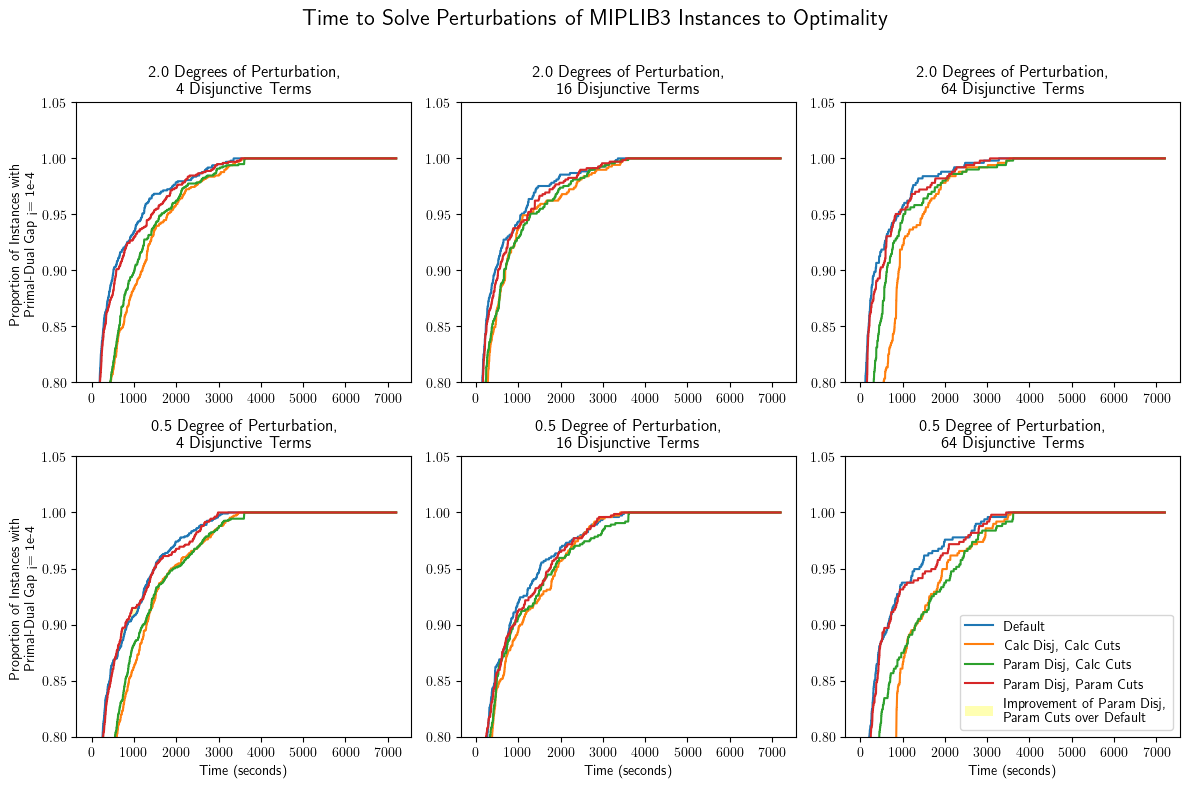

In [57]:
make_plots(time_df, "terminationTime", show_all=True)

# Make node table

In [58]:
# additional filtering for dataframe on nodes processed
fields = ["nodes New", "nodes Old", "nodes Farkas",
          "nodes None", "terminationTimeImprovement"]
node_df = df.loc[mask, group_cols + id_cols + fields]
for f in fields:
    node_df[f] = node_df[f] / 1000

# define aggregating operations
aggregations = {f: "mean" for f in fields}
aggregations["instance"] = "nunique"
aggregations["instanceIndex"] = "count"

# get gap closed by degree and term
out = node_df.groupby(["degree", "terms"]).agg(aggregations).reset_index()
out.to_csv(os.path.join(out_fldr, "node.csv"), index=False, mode="w")
out

,degree,terms,nodes New,nodes Old,nodes Farkas,nodes None,terminationTimeImprovement,instance,instanceIndex
0,0.5,4,226.888077,238.964045,222.105013,230.508469,-0.000259,155,1080
1,0.5,16,265.689643,283.442427,285.139047,277.609726,-0.000795,118,740
2,0.5,64,127.280380,125.808479,116.182677,125.764469,-0.002116,88,495
3,2.0,4,196.035903,190.398621,186.621397,189.211629,-0.000732,157,981
4,2.0,16,254.151528,263.457730,258.867626,255.943012,-0.002068,116,690
5,2.0,64,112.740333,110.138935,105.645187,116.308371,-0.004142,87,504


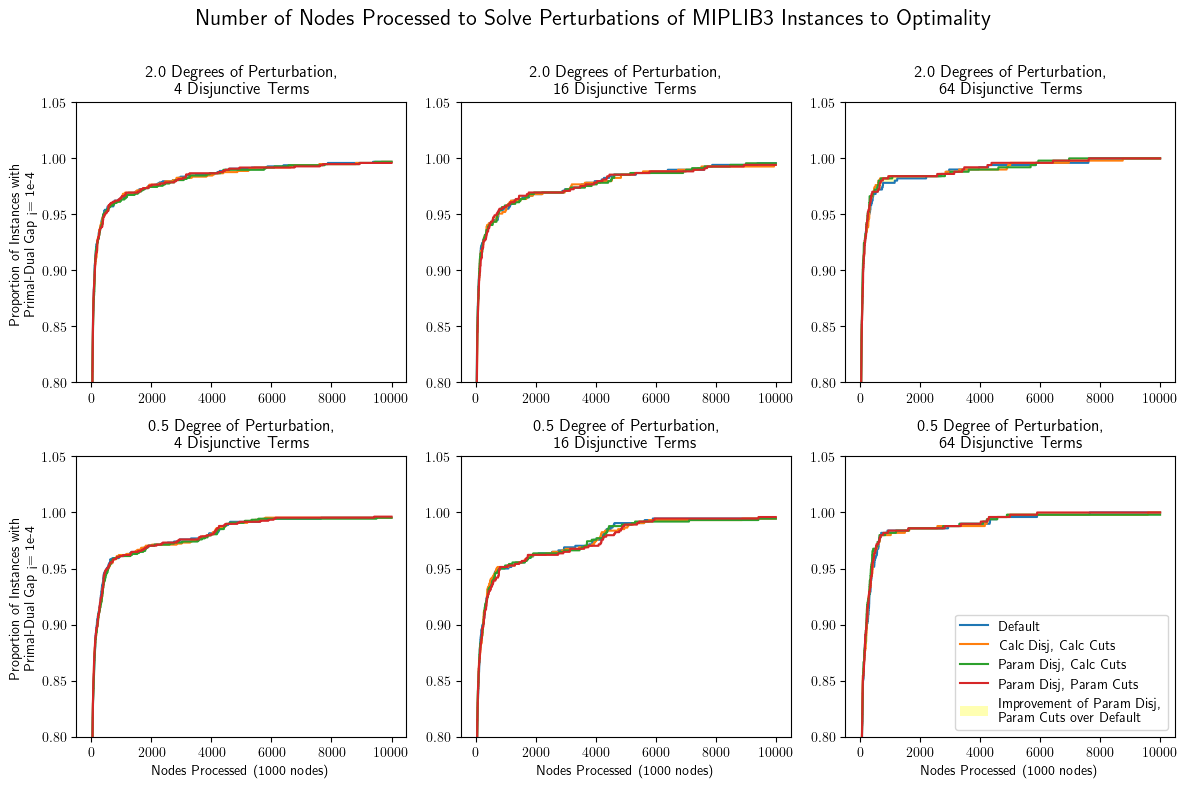

In [59]:
make_plots(node_df, "nodes", show_all=True)

# Make iteration table

In [60]:
# additional filtering for dataframe on nodes processed
fields = ["iterations New", "iterations Old",
          "iterations Farkas", "iterations None",
          "terminationTimeImprovement"]
iteration_df = df.loc[mask, group_cols + id_cols + fields]
for f in fields:
    iteration_df[f] = iteration_df[f] / 1000

# define aggregating operations
aggregations = {f: "mean" for f in fields}
aggregations["instance"] = "nunique"
aggregations["instanceIndex"] = "count"

# get gap closed by degree and term
out = iteration_df.groupby(["degree", "terms"]).agg(aggregations).reset_index()
out.to_csv(os.path.join(out_fldr, "iteration.csv"), index=False, mode="w")
out

,degree,terms,iterations New,iterations Old,iterations Farkas,iterations None,terminationTimeImprovement,instance,instanceIndex
0,0.5,4,1895.064302,2047.658631,1886.639523,1872.800576,-0.000259,155,1080
1,0.5,16,2067.844843,2102.385122,2150.929431,2070.595158,-0.000795,118,740
2,0.5,64,1811.026586,1696.523172,1706.980651,1725.993463,-0.002116,88,495
3,2.0,4,1584.354110,1608.031580,1590.540141,1526.988964,-0.000732,157,981
4,2.0,16,1672.616235,1693.664820,1720.534255,1666.591219,-0.002068,116,690
5,2.0,64,1244.725397,1185.959887,1197.376673,1223.408512,-0.004142,87,504


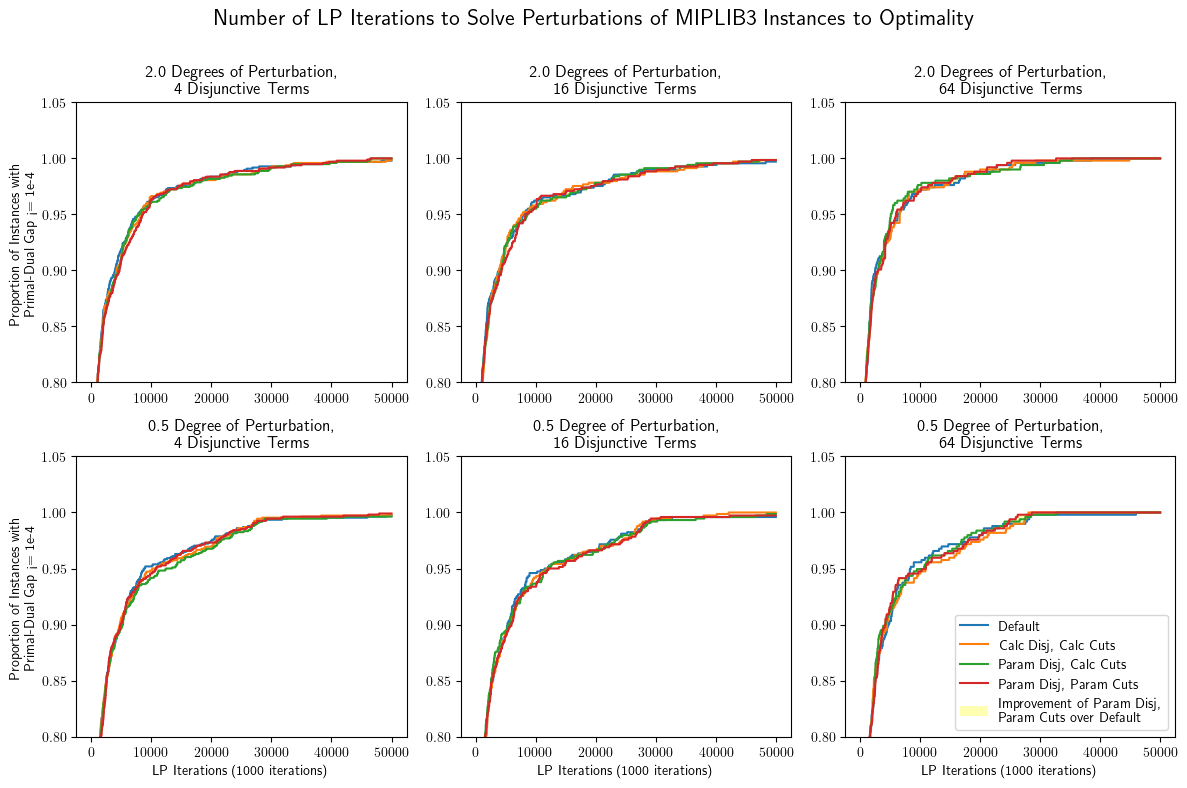

In [61]:
make_plots(iteration_df, "iterations", show_all=True)

## Improvement Consistency

In [62]:
def make_run_time_boxplot(time_df, perturbation=None, threshold=.1):
    plt.rc('text', usetex=True)  # use latex fonts

    # Get unique values of degree and terms
    degrees = time_df['degree'].sort_values(ascending=False).unique()  # sort increasing
    terms = time_df['terms'].sort_values().unique()  # sort decreasing
    
    # Create a grid of subplots
    fig, axes = plt.subplots(len(degrees), len(terms), figsize=(8*len(terms), 4*len(degrees)))
    
    # Iterate through each combination of degree and terms
    for i, degree in enumerate(degrees):
        for j, term in enumerate(terms):
            
            # get the data for this combination
            subset = time_df[(time_df['terms'] == term) &
                             (time_df['degree'] == degree)]
            
            # if we are looking at a specific perturbation, filter for it
            if perturbation is not None:
                subset = subset[subset["perturbation"] == perturbation]
                
            cut_off = subset["terminationTimeImprovement"].quantile(1 - threshold)
            
            # now break it down by instance
            unique_instances = subset['instance'].sort_values().unique()
            instance_data = [subset[subset['instance'] == instance]['terminationTimeImprovement'].tolist()
                             for instance in unique_instances]
            
            # make all the boxplots for this plot
            axes[i, j].boxplot(instance_data, labels=unique_instances)
            axes[i, j].axhline(cut_off, color='black', linestyle='--', linewidth=1, alpha=.5, label=f"Top {int(threshold * 100)} Percent of Instances")
            axes[i, j].set_ylim(-3, 1)
            axes[i, j].set_xticklabels(axes[i, j].get_xticklabels(), rotation=90)
            axes[i, j].set_title(f"{degree} Degree{'s' if degree >= 2 else ''} "
                                 f"of Perturbation,\n{term} Disjunctive Terms")
            if j == 0:
                axes[i, j].set_ylabel('Relative Time Improvement\n'
                                      '(Param Disj, Param Cuts vs Default)')
            if i == len(degrees) - 1:
                axes[i, j].set_xlabel('Instance')
    
    fig.suptitle(f"Distributions of Relative Time Improvement for Param Disj, "
                 f"Param Cuts compared to Default"
                 f"{' - perturbing only ' + perturbation if perturbation else ''}\n"
                 f"(positive values imply Param Disj, Param Cuts'"
                 f" run time faster than Default's)", fontsize=16)
    
    plt.tight_layout()
    plt.savefig(os.path.join(out_fldr, f"time_improvement_distribution"
                                       f"{'_' + perturbation if perturbation else ''}.png"),
                dpi=1200)
    plt.legend()
    plt.show()

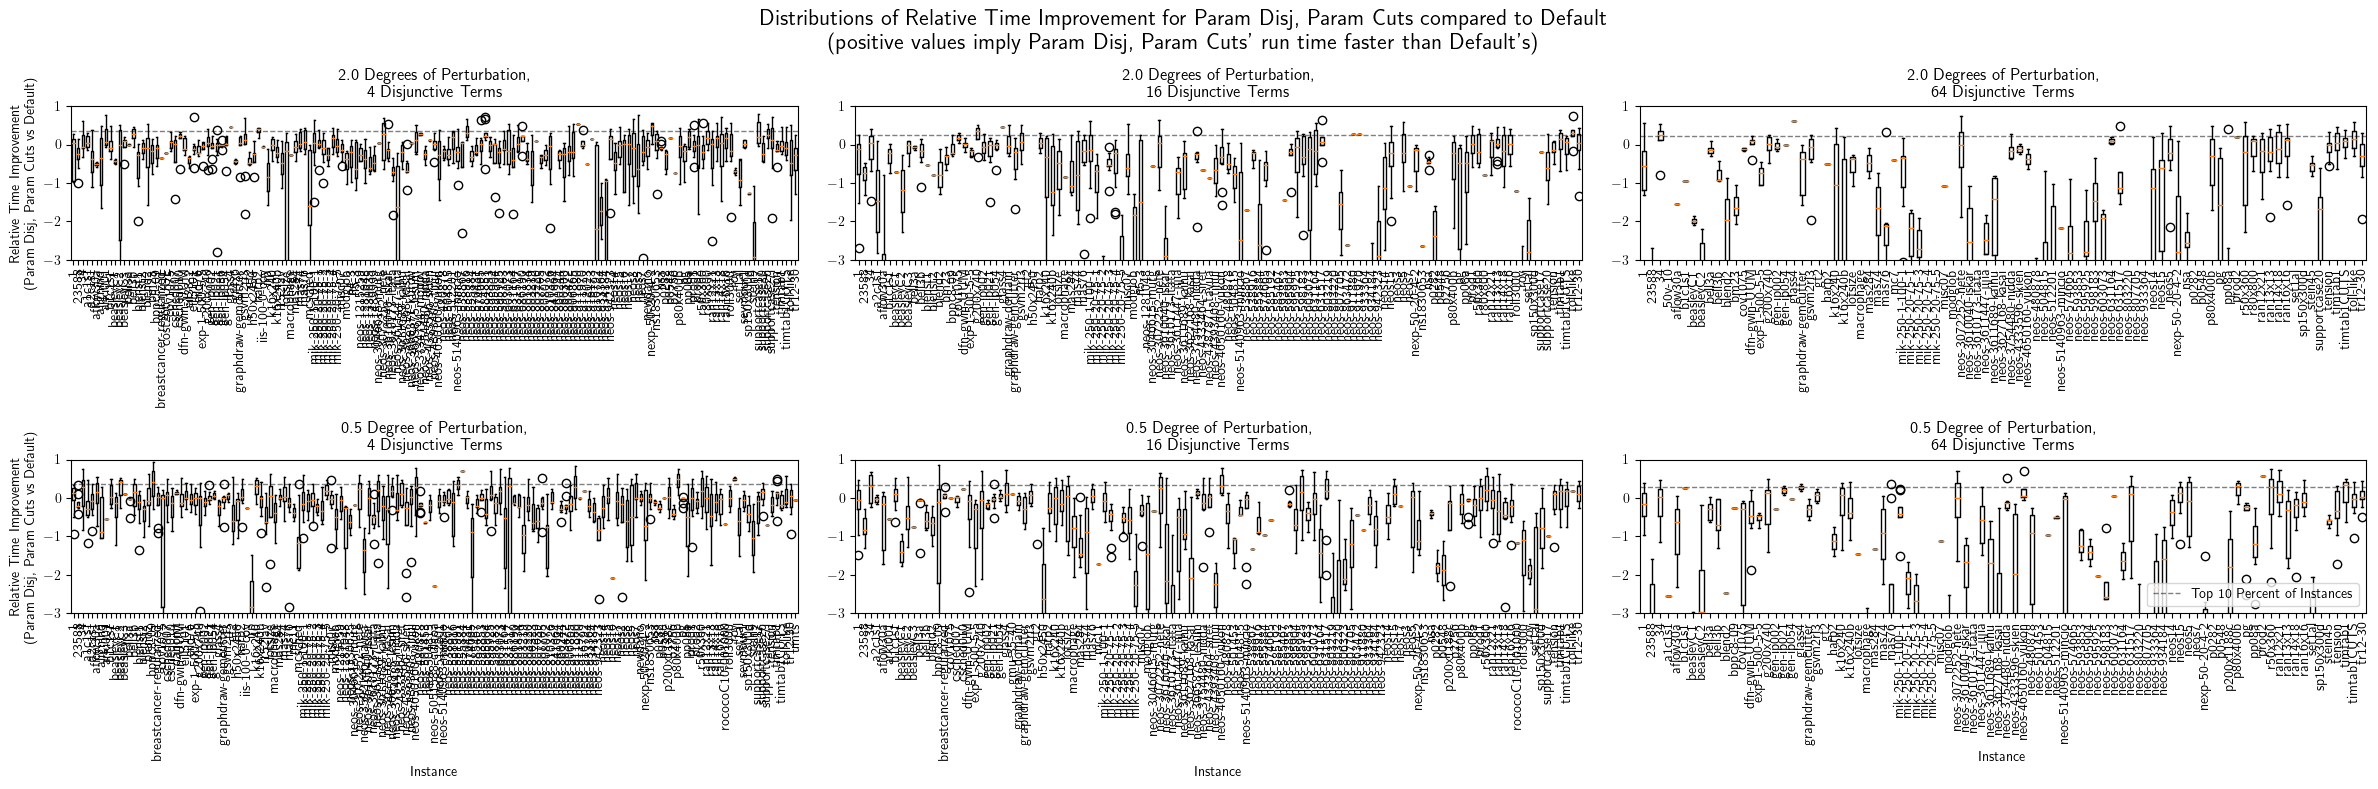

In [63]:
make_run_time_boxplot(time_df)

In [64]:
df_zero = df_map["None"].loc[(df_map["None"]["instanceIndex"] == 0) & (optimality_gap(df_map["None"]) <= 1e-4)]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


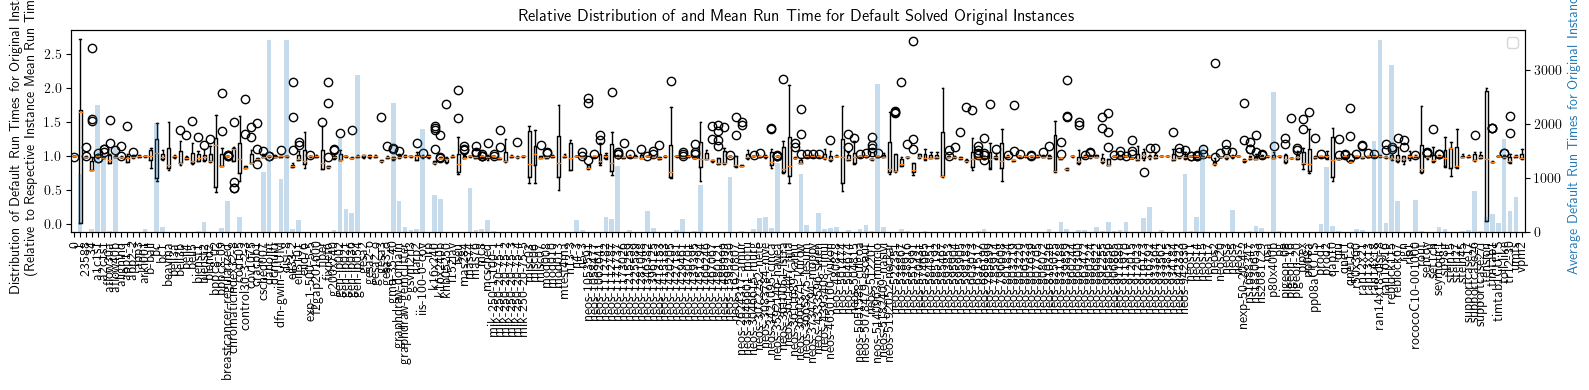

In [65]:
# configure plot
plt.rc('text', usetex=True)
fig, ax1 = plt.subplots(figsize=(16, 4))

# now break it down by instance
mean_run = df_zero.groupby("instance")["terminationTime"].mean().to_dict()
data = {instance: df_zero[df_zero['instance'] == instance]['terminationTime'].values / time
         for instance, time in mean_run.items()}

# make all the boxplots for this plot
ax1.boxplot(data.values(), labels=data.keys())
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
ax1.set_ylabel('Distribution of Default Run Times for Original Instances\n'
               '(Relative to Respective Instance Mean Run Time)')
ax1.set_title("Relative Distribution of and Mean Run Time for Default Solved Original Instances")

# make the barchart for this plot
ax2 = ax1.twinx()
color = 'tab:blue'
plt.bar(np.arange(1, len(mean_run) + 1), mean_run.values(), alpha=.25, color=color)
ax2.set_ylabel('Average Default Run Times for Original Instances', color=color)

plt.tight_layout()
plt.savefig(os.path.join(out_fldr, "original_distribution.png"), dpi=1200)
plt.legend()
plt.show()

## Check Root Optimality Gap Relationships

In [66]:
gap_df = df.loc[mask]  # & (df["terms"] == 64) & (df["degree"] == .5)]

In [67]:
gap_df.columns

Index(['instanceIndex', 'vpcGenerator None', 'terms', 'lpBound None',
       'disjunctiveDualBound None', 'lpBoundPostVpc None',
       'rootDualBound None', 'dualBound None', 'primalBound None',
       'vpcGenerationTime None',
       ...
       'rootDualBoundTimeSansVpc New', 'rootDualBoundTimeSansVpc Old',
       'rootDualBoundTimeSansVpc Farkas', 'postRootTime None',
       'postRootTime New', 'postRootTime Old', 'postRootTime Farkas',
       'terminationTimeImprovement', 'nodeImprovement',
       'iterationImprovement'],
      dtype='object', length=106)

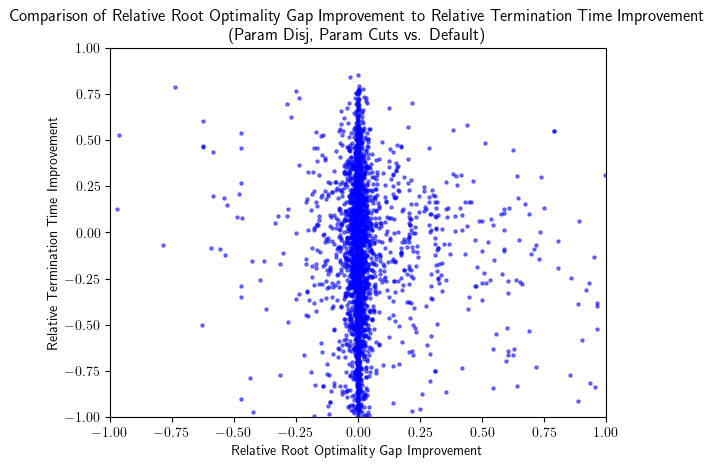

In [68]:
plt.scatter(gap_df["Root Optimality Gap Improvement"], gap_df["terminationTimeImprovement"],
            marker='o', color='blue', s=5, alpha=0.5)
plt.ylim(-1, 1)
plt.xlim(-1, 1)
plt.title("Comparison of Relative Root Optimality Gap Improvement to Relative Termination Time Improvement\n"
          "(Param Disj, Param Cuts vs. Default)")
plt.xlabel("Relative Root Optimality Gap Improvement")
plt.ylabel("Relative Termination Time Improvement")
plt.savefig(os.path.join(out_fldr, "gap_vs_time.png"), dpi=1200)
plt.show()

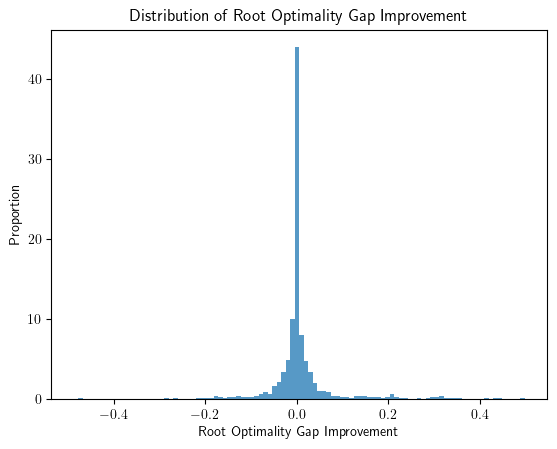

In [69]:
# Create a histogram with 100 bins
plt.hist(gap_df.loc[(-.5 < gap_df["Root Optimality Gap Improvement"]) & (gap_df["Root Optimality Gap Improvement"] < .5),
                    "Root Optimality Gap Improvement"], bins=100, density=True, alpha=0.75)

# Add labels and a title
plt.xlabel('Root Optimality Gap Improvement')
plt.ylabel('Proportion')
plt.title('Distribution of Root Optimality Gap Improvement')

# Display the plot
plt.show()

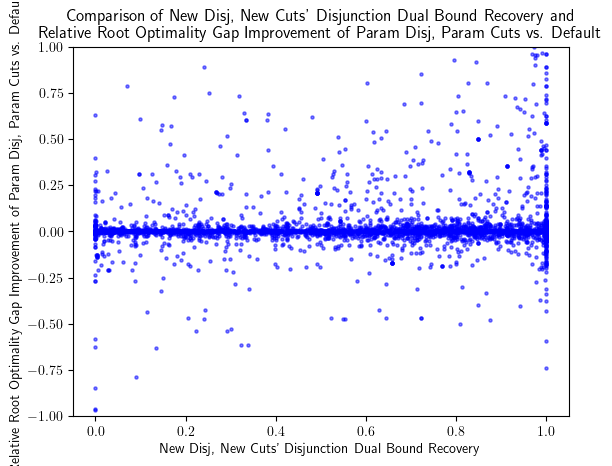

In [70]:
# is there a relationship between how much of dual bound we recover and root optimality gap improvement
plt.scatter(gap_df["VPCs (New)"] / gap_df["Disjunction (New)"],
            gap_df["Root Optimality Gap Improvement"],
            marker='o', color='blue', s=5, alpha=0.5)
plt.ylim(-1, 1)
plt.title("Comparison of New Disj, New Cuts' Disjunction Dual Bound Recovery and\n"
          "Relative Root Optimality Gap Improvement of Param Disj, Param Cuts vs. Default")
plt.xlabel("New Disj, New Cuts' Disjunction Dual Bound Recovery")
plt.ylabel("Relative Root Optimality Gap Improvement of Param Disj, Param Cuts vs. Default")
plt.show()

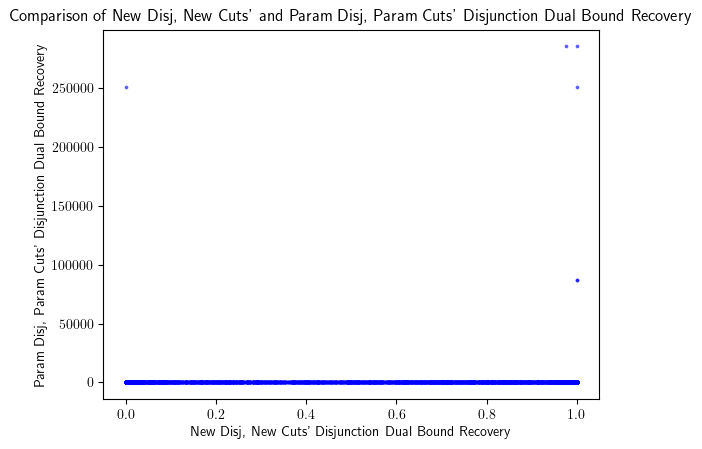

In [71]:
# is there a relationship between how much of dual bound we recover with New vs Farkas VPCs
plt.scatter(gap_df["VPCs (New)"] / gap_df["Disjunction (New)"],
            gap_df["VPCs (Farkas)"] / gap_df["Disjunction (Old)"],
            marker='o', color='blue', s=3, alpha=0.5)
plt.title("Comparison of New Disj, New Cuts' and Param Disj, Param Cuts' Disjunction Dual Bound Recovery")
plt.xlabel("New Disj, New Cuts' Disjunction Dual Bound Recovery")
plt.ylabel("Param Disj, Param Cuts' Disjunction Dual Bound Recovery")
plt.show()  # todo: what happens when Param Disj, Param Cuts recovers the same amount of dual bound?

In [72]:
df.columns

Index(['instanceIndex', 'vpcGenerator None', 'terms', 'lpBound None',
       'disjunctiveDualBound None', 'lpBoundPostVpc None',
       'rootDualBound None', 'dualBound None', 'primalBound None',
       'vpcGenerationTime None',
       ...
       'rootDualBoundTimeSansVpc New', 'rootDualBoundTimeSansVpc Old',
       'rootDualBoundTimeSansVpc Farkas', 'postRootTime None',
       'postRootTime New', 'postRootTime Old', 'postRootTime Farkas',
       'terminationTimeImprovement', 'nodeImprovement',
       'iterationImprovement'],
      dtype='object', length=106)

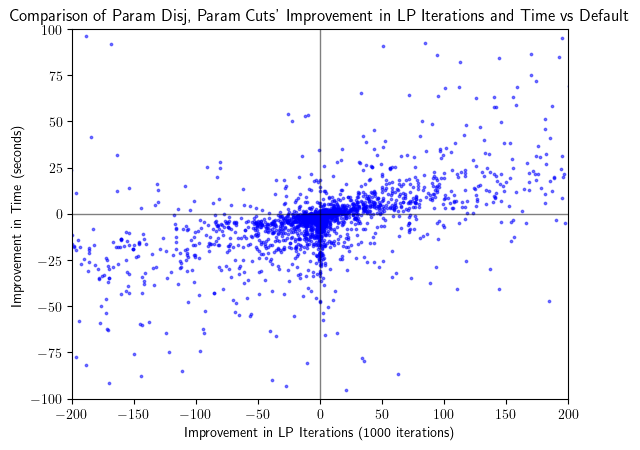

In [73]:
# plot iteration improvement over termination time improvement
# is there a relationship between how much of dual bound we recover with New vs Farkas VPCs
plt.scatter(gap_df["iterations None"]/1000 - gap_df["iterations Farkas"]/1000,
            gap_df["terminationTime None"] - gap_df["terminationTime Farkas"],
            marker='o', color='blue', s=3, alpha=0.5)
plt.xlim(-200, 200)
plt.ylim(-100, 100)
plt.axvline(0, color='black', linestyle='-', linewidth=1, alpha=.5)
plt.axhline(0, color='black', linestyle='-', linewidth=1, alpha=.5)
plt.title("Comparison of Param Disj, Param Cuts' Improvement in LP Iterations and Time vs Default")
plt.xlabel("Improvement in LP Iterations (1000 iterations)")
plt.ylabel("Improvement in Time (seconds)")
plt.savefig(os.path.join(out_fldr, "lp_iters_vs_time.png"), dpi=1200)
plt.show()

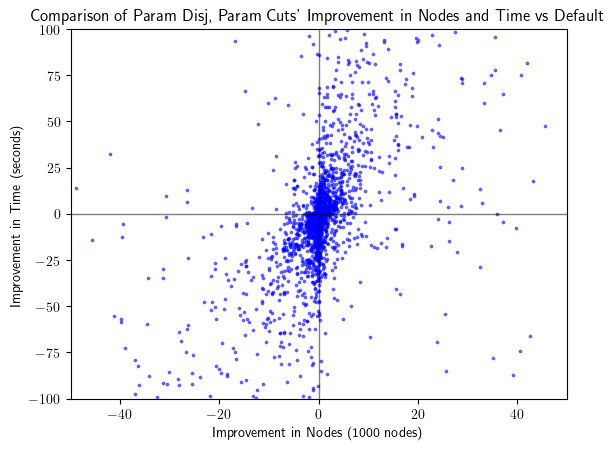

In [74]:
# plot iteration improvement over termination time improvement
# is there a relationship between how much of dual bound we recover with New vs Farkas VPCs
plt.scatter(gap_df["nodes None"]/1000 - gap_df["nodes Farkas"]/1000,
            gap_df["terminationTime None"] - gap_df["terminationTime Farkas"],
            marker='o', color='blue', s=3, alpha=0.5)
plt.xlim(-50, 50)
plt.ylim(-100, 100)
plt.axvline(0, color='black', linestyle='-', linewidth=1, alpha=.5)
plt.axhline(0, color='black', linestyle='-', linewidth=1, alpha=.5)
plt.title("Comparison of Param Disj, Param Cuts' Improvement in Nodes and Time vs Default")
plt.xlabel("Improvement in Nodes (1000 nodes)")
plt.ylabel("Improvement in Time (seconds)")
plt.savefig(os.path.join(out_fldr, "nodes_vs_time.png"), dpi=1200)
plt.show()

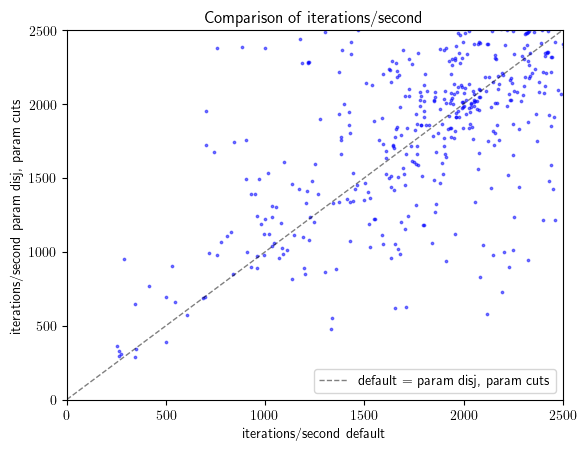

In [75]:
# plot iteration improvement over termination time improvement
# is there a relationship between how much of dual bound we recover with New vs Farkas VPCs
plt.scatter(gap_df["iterations Farkas"]/gap_df["terminationTimeSansVpc Farkas"],
            gap_df["iterations None"]/gap_df["terminationTimeSansVpc None"],
            marker='o', color='blue', s=3, alpha=0.5)
# plot the line y = x
x = np.linspace(0, 3000, 3000)
plt.plot(x, x, linestyle='--', color='black', linewidth=1, alpha=.5,
         label="default = param disj, param cuts")
plt.xlim(0, 2500)
plt.ylim(0, 2500)
plt.title("Comparison of iterations/second")
plt.xlabel("iterations/second default")
plt.ylabel("iterations/second param disj, param cuts")
plt.legend()
plt.savefig(os.path.join(out_fldr, "lp_iters_per_second.png"), dpi=1200)
plt.show()

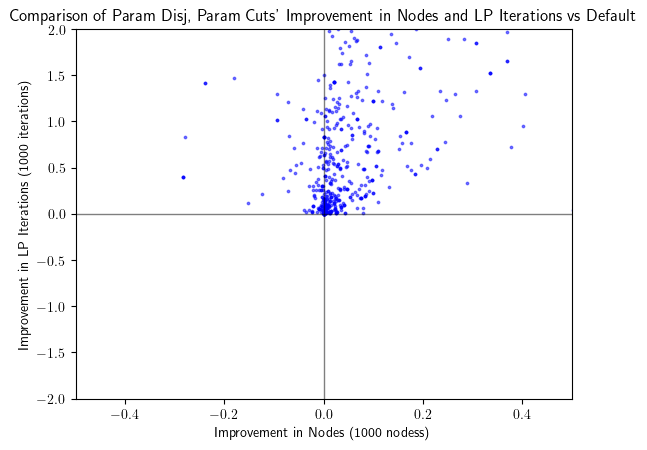

In [76]:
# plot node improvement over iteration improvement
# is there a relationship between how much of dual bound we recover with New vs Farkas VPCs
tdf = gap_df.loc[(gap_df["iterationImprovement"] > 0) & (gap_df["terminationTimeImprovement"] < 0)]
plt.scatter(tdf["nodes None"]/1000 - tdf["nodes Farkas"]/1000,
            tdf["iterations None"]/1000 - tdf["iterations Farkas"]/1000,
            marker='o', color='blue', s=3, alpha=0.5)
plt.xlim(-.5, .5)
plt.ylim(-2, 2)
plt.axvline(0, color='black', linestyle='-', linewidth=1, alpha=.5)
plt.axhline(0, color='black', linestyle='-', linewidth=1, alpha=.5)
plt.title("Comparison of Param Disj, Param Cuts' Improvement in Nodes and LP Iterations vs Default")
plt.xlabel("Improvement in Nodes (1000 nodess)")
plt.ylabel("Improvement in LP Iterations (1000 iterations)")
plt.savefig(os.path.join(out_fldr, "nodes_vs_lp_iters_werid.png"), dpi=1200)
plt.show()

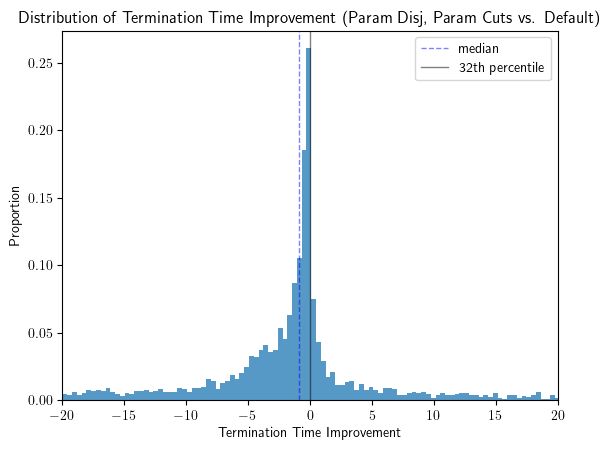

In [77]:
# Create a histogram with 600 bins
plt.hist(gap_df["terminationTime None"] - gap_df["terminationTime Farkas"],
         bins=14400, density=True, alpha=0.75)
plt.xlim(-20, 20)

cut_off = (gap_df["terminationTime None"] - gap_df["terminationTime Farkas"]).quantile(.5)
zeroth_percentile = int(100 * round((gap_df["terminationTime None"] >= gap_df["terminationTime Farkas"]).sum() / len(gap_df), 2))
plt.axvline(cut_off, color='blue', linestyle='--', linewidth=1, alpha=.5, label=f"median")
plt.axvline(0, color='black', linestyle='-', linewidth=1, alpha=.5, label=f"{zeroth_percentile}th percentile")

# Add labels and a title
plt.xlabel('Termination Time Improvement')
plt.ylabel('Proportion')
plt.title('Distribution of Termination Time Improvement (Param Disj, Param Cuts vs. Default)')

# Display the plot
plt.legend()
plt.savefig(os.path.join(out_fldr, "time_improvement_distribution.png"), dpi=1200)
plt.show()

In [78]:
gap_df

,instanceIndex,vpcGenerator None,terms,lpBound None,disjunctiveDualBound None,lpBoundPostVpc None,rootDualBound None,dualBound None,primalBound None,vpcGenerationTime None,...,rootDualBoundTimeSansVpc New,rootDualBoundTimeSansVpc Old,rootDualBoundTimeSansVpc Farkas,postRootTime None,postRootTime New,postRootTime Old,postRootTime Farkas,terminationTimeImprovement,nodeImprovement,iterationImprovement
8,1,None,16,906793.399681,906793.399681,906793.399681,9.106540e+06,9.135598e+06,9.135926e+06,0.000003,...,0.531730,0.537845,0.668578,28.238741,32.148449,33.349645,34.894502,-0.466115,0.162301,-0.096603
10,1,None,4,-592402.206414,-592402.206414,-592402.206414,-1.042603e+05,-1.031375e+05,-1.031287e+05,0.000003,...,0.332280,0.436018,0.347002,0.227246,0.356746,0.169076,0.169288,-0.529030,0.237500,0.207214
12,1,None,4,2432.537572,2432.537572,2432.537572,2.569921e+03,2.691000e+03,2.691000e+03,0.000004,...,2.802128,3.242163,2.892319,303.822601,860.635573,373.217989,289.348552,0.033490,0.044731,0.070068
13,2,None,4,2455.531372,2455.531372,2455.531372,2.647265e+03,2.724000e+03,2.724000e+03,0.000003,...,3.573090,3.914333,3.633250,384.502049,252.204207,253.212253,272.675764,0.277344,0.204364,0.275644
14,3,None,4,2469.341086,2469.341086,2469.341086,2.599561e+03,2.672000e+03,2.672000e+03,0.000003,...,5.019150,3.663157,4.888740,79.742527,159.748921,209.677482,162.224651,-1.050750,-0.917246,-0.337061
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10399,1,None,16,0.010856,0.010856,0.010856,3.921800e-02,3.212280e-01,3.212280e-01,0.000003,...,0.175697,0.209842,0.167411,65.093324,225.266261,59.700633,96.976673,-0.499740,-0.887260,-0.745557
10400,2,None,16,0.010572,0.010572,0.010572,2.586600e-02,1.781850e-01,1.781980e-01,0.000003,...,0.172782,0.246196,0.221854,12.053965,16.711920,9.545135,7.368141,0.311664,0.390799,0.430188
10401,3,None,16,0.009762,0.009762,0.009762,3.630900e-02,2.529310e-01,2.529480e-01,0.000003,...,0.220907,0.203528,0.204797,232.206049,76.720969,128.606057,115.179721,0.500258,0.477367,0.486380
10402,4,None,16,0.011922,0.011922,0.011922,4.483900e-02,3.299570e-01,3.299870e-01,0.000003,...,0.210623,0.184038,0.189167,573.806967,476.403870,389.181579,385.333899,0.327052,0.290765,0.274887


## See Where My Work Went off the Rails

In [79]:
# create a table to compare unperturbed instances with aleks' results for them
groups = ["instance", "terms"]
fields = ["lpBound New", "disjunctiveDualBound New", "lpBoundPostVpc New", "rootDualBound None",
          "rootDualBound New", "primalBound None", "terminationTime None", "Root Cuts (New)", "Root Cuts (None)"]
comp = df.loc[df["instanceIndex"] == 0, groups + fields].groupby(groups).mean().reset_index()
comp.to_csv(os.path.join(out_fldr, "unperturbed_bound_table.csv"), index=False, mode="w")
comp

,instance,terms,lpBound New,disjunctiveDualBound New,lpBoundPostVpc New,rootDualBound None,rootDualBound New,primalBound None,terminationTime None,Root Cuts (New),Root Cuts (None)
0,1,4,4.662510e+03,4.677023e+03,4.676553e+03,4.894897e+03,4.901976e+03,5.089364e+03,1044.112652,0.636084,0.616865
1,1,16,4.662510e+03,4.693364e+03,4.689320e+03,4.894897e+03,4.888646e+03,5.089364e+03,1089.174432,0.604271,0.616865
2,1,64,4.662510e+03,4.707372e+03,4.698058e+03,4.894897e+03,4.905664e+03,5.089364e+03,1084.000808,0.611647,0.616865
3,23588,4,7.649866e+03,7.799913e+03,7.774120e+03,7.770368e+03,7.797326e+03,8.090000e+03,1.710106,0.335035,0.273784
4,23588,16,7.649866e+03,7.867861e+03,7.862267e+03,7.770368e+03,7.867450e+03,8.090000e+03,1.668357,0.494358,0.273784
...,...,...,...,...,...,...,...,...,...,...,...
333,toll-like,4,3.600000e+01,4.650000e+01,4.000000e+01,5.624141e+02,5.577792e+02,6.100000e+02,1714.899397,0.909023,0.917098
334,tr12-30,4,2.530221e+04,2.561136e+04,2.549848e+04,1.291467e+05,1.290908e+05,1.305960e+05,368.690706,0.985705,0.986236
335,tr12-30,16,2.530221e+04,2.654664e+04,2.580549e+04,1.291467e+05,1.290908e+05,1.305960e+05,410.448534,0.985705,0.986236
336,tr12-30,64,2.530221e+04,2.713795e+04,2.572180e+04,1.291467e+05,1.290908e+05,1.305960e+05,403.133095,0.985705,0.986236


In [140]:
# create a table with aleks's results for the unperturbed instances 
adf = pd.read_csv("aleks_results.csv")
adf = adf[["INSTANCE", "disj_terms", "LP OBJ", "BEST DISJ OBJ", "VPC OBJ", "AVG REF LAST_CUT_PASS", "AVG REF+V LAST_CUT_PASS", "ip_obj", "BEST REF TIME"]]
adf["rcnew"] = abs(adf["AVG REF+V LAST_CUT_PASS"] - adf["LP OBJ"]) / abs(adf["ip_obj"] - adf["LP OBJ"]) 
adf["rcnone"] = abs(adf["AVG REF LAST_CUT_PASS"] - adf["LP OBJ"]) / abs(adf["ip_obj"] - adf["LP OBJ"])
adf.columns = groups + fields
adf['instance'] = adf['instance'].str.replace('_presolved', '')
adf['instance'] = adf['instance'].str.replace('mas0', 'mas')
adf = adf.loc[(0 <= adf["Root Cuts (New)"]) & (adf["Root Cuts (New)"] <= 1)]

In [141]:
# join comp and adf on instance and terms to get a comparison of the two and see what's missing
keep_cols = groups + ["Root Cuts (New)", "Root Cuts (None)", "terminationTime None"]
both = comp[keep_cols].merge(adf[keep_cols], on=groups, suffixes=(" sean", " aleks"), how="outer")
both

,instance,terms,Root Cuts (New) sean,Root Cuts (None) sean,terminationTime None sean,Root Cuts (New) aleks,Root Cuts (None) aleks,terminationTime None aleks
0,1,4.0,0.636084,0.616865,1044.112652,NaN,NaN,NaN
1,1,16.0,0.604271,0.616865,1089.174432,NaN,NaN,NaN
2,1,64.0,0.611647,0.616865,1084.000808,NaN,NaN,NaN
3,23588,4.0,0.335035,0.273784,1.710106,0.318880,0.243813,0.420
4,23588,16.0,0.494358,0.273784,1.668357,0.487854,0.243813,0.424
...,...,...,...,...,...,...,...,...
2099,umts,64.0,NaN,NaN,NaN,0.049433,0.047454,49.839
2100,usAbbrv-8-25_70,64.0,NaN,NaN,NaN,0.000000,0.000000,3600.000
2101,vpm1,64.0,NaN,NaN,NaN,0.721295,0.681575,0.004
2102,vpm2,64.0,NaN,NaN,NaN,0.719205,0.718862,0.098


In [142]:
# make a dataframe that compares the experiments we both ran
diff = both.loc[~pd.isna(both["Root Cuts (New) sean"]) & ~pd.isna(both["Root Cuts (New) aleks"])]
diff["improvement aleks"] = (diff["Root Cuts (New) aleks"] - diff["Root Cuts (None) aleks"]) / diff["Root Cuts (None) aleks"]

# get some summary stats - looks like we are pretty close
# I expect the difference is that I'm running in debug mode (time) and not adding GMICs 
diff[diff.columns[2:]].mean()

/var/folders/pb/p1sshdnx5sv12zwsxff8nrg40000gn/T/ipykernel_5163/26002794.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diff["improvement aleks"] = (diff["Root Cuts (New) aleks"] - diff["Root Cuts (None) aleks"]) / diff["Root Cuts (None) aleks"]


Root Cuts (New) sean            0.527243
Root Cuts (None) sean           0.518026
terminationTime None sean     460.643675
Root Cuts (New) aleks           0.532178
Root Cuts (None) aleks          0.515030
terminationTime None aleks    241.963819
improvement aleks                    inf
dtype: float64

In [143]:
# let's examine the instances for which I don't have data
mdf = both.loc[(both["Root Cuts (None) sean"].isna()) & (both["terms"].isin([4, 16, 64])),
               ["instance", "terms", "Root Cuts (New) aleks", "Root Cuts (None) aleks", "terminationTime None aleks"]]
mdf.columns = ["instance", "terms", "Root Cuts (New)", "Root Cuts (None)", "terminationTime None"]
mdf["improvement"] = (mdf["Root Cuts (New)"] - mdf["Root Cuts (None)"]) / mdf["Root Cuts (None)"]
mdf

,instance,terms,Root Cuts (New),Root Cuts (None),terminationTime None,improvement
688,22433,4.0,0.675821,0.667379,0.093,0.012649
689,10teams,4.0,1.000000,1.000000,0.301,0.000000
690,30n20b8,4.0,0.163007,0.169100,10.769,-0.036033
691,air01,4.0,0.929825,0.929825,0.002,0.000000
692,app1-1,4.0,0.963683,0.948931,0.243,0.015545
...,...,...,...,...,...,...
2099,umts,64.0,0.049433,0.047454,49.839,0.041720
2100,usAbbrv-8-25_70,64.0,0.000000,0.000000,3600.000,NaN
2101,vpm1,64.0,0.721295,0.681575,0.004,0.058276
2102,vpm2,64.0,0.719205,0.718862,0.098,0.000477


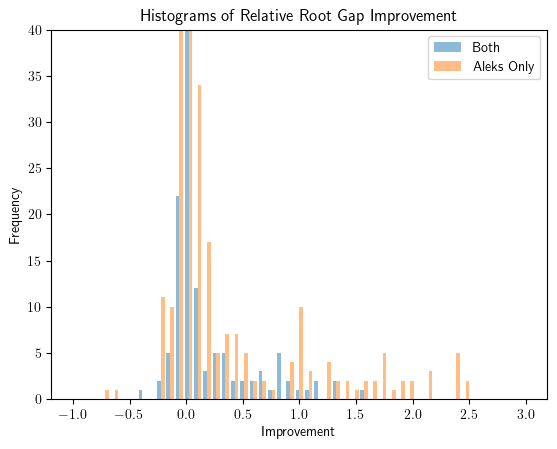

In [144]:
# Plot histograms
plt.hist([diff["improvement aleks"], mdf["improvement"]], bins=np.linspace(-1, 3, 50), alpha=0.5, label=['Both', 'Aleks Only'])

plt.ylim(0, 40)

# Add labels and title
plt.xlabel('Improvement')
plt.ylabel('Frequency')
plt.title('Histograms of Relative Root Gap Improvement')

# Add legend
plt.legend()

# Show the plot
plt.show()

In [145]:
# set the index of mdf to the combination of instance and terms
mdf = mdf.set_index(["instance", "terms"])
mdf

,,Root Cuts (New),Root Cuts (None),terminationTime None,improvement
instance,terms,,,,
22433,4.0,0.675821,0.667379,0.093,0.012649
10teams,4.0,1.000000,1.000000,0.301,0.000000
30n20b8,4.0,0.163007,0.169100,10.769,-0.036033
air01,4.0,0.929825,0.929825,0.002,0.000000
app1-1,4.0,0.963683,0.948931,0.243,0.015545
...,...,...,...,...,...
umts,64.0,0.049433,0.047454,49.839,0.041720
usAbbrv-8-25_70,64.0,0.000000,0.000000,3600.000,NaN
vpm1,64.0,0.721295,0.681575,0.004,0.058276


In [146]:
# classify missing experiment data by excluded instance (either aleks' mislabeled or I just missed), max run time, unperturbable, or run time error
mdf["reason"] = "unknown"

# read in list of dropped instances from aleks' data set
# i think the issue is some aleks tested despite saying he wasn't and others were more than 5k x 5k rows but preprocess to less
dropped = pd.read_csv("dropped.csv", index_col="instance")

for (instance, terms) in mdf.index:
    cur_inst_test_set_fldr = os.path.join(test_set_fldr, instance)
    if instance + ".mps" not in os.listdir(instance_fldr):
        if instance in dropped.index:
            mdf.loc[(instance, terms), "reason"] = "dropped"
        else:
            mdf.loc[(instance, terms), "reason"] = "missed"
    elif mdf.loc[(instance, terms), "terminationTime None"] > 3599:
        mdf.loc[(instance, terms), "reason"] = "max run time"
    elif not os.path.exists(cur_inst_test_set_fldr) or not os.listdir(cur_inst_test_set_fldr):
        mdf.loc[(instance, terms), "reason"] = "unperturbable"
    else:
        mdf.loc[(instance, terms), "reason"] = "runtime error"

In [147]:
# summary stats on where our improving runs are hiding
mdf.groupby("reason").agg({'Root Cuts (New)': 'mean', 'Root Cuts (None)': 'mean', 'improvement': 'count'}).reset_index()

,reason,Root Cuts (New),Root Cuts (None),improvement
0,dropped,0.480467,0.412771,66
1,max run time,0.376882,0.373193,71
2,missed,0.463860,0.430659,114
3,runtime error,0.508916,0.463584,384
4,unperturbable,0.207571,0.207572,5


In [148]:
# track down the experiments we excluded because we missed creating them
missing = mdf[mdf["reason"] == "missed"].reset_index().drop_duplicates("instance").sort_values("instance")
missing

,instance,terms,Root Cuts (New),Root Cuts (None),terminationTime None,improvement,reason
0,30n20b8,4.0,0.163007,0.169100,10.769,-0.036033,missed
1,blp-ir98,4.0,0.900129,0.895645,0.993,0.005007,missed
2,cap6000,4.0,0.039139,0.037568,0.070,0.041833,missed
3,dg012142,4.0,0.010542,0.011027,3600.000,-0.043975,missed
4,fastxgemm-n2r6s0t2,4.0,0.133005,0.133005,0.000,0.000000,missed
5,graph20-20-1rand,4.0,0.000000,0.000000,3600.000,NaN,missed
6,gus-sch,4.0,0.936173,0.942404,0.249,-0.006611,missed
7,hgms-det,4.0,0.020026,0.026136,3600.000,-0.233790,missed
8,lectsched-4-obj,4.0,1.000000,1.000000,0.047,0.000000,missed
9,lrn,4.0,0.771781,0.773766,12.072,-0.002565,missed


In [ ]:
instance_list = os.listdir(instance_fldr)
for instance in missing["instance"]:
    

In [149]:
# let's look at what aleks "missed"
aleks_missing = both.loc[pd.isna(both["Root Cuts (New) aleks"])].drop_duplicates("instance").sort_values("instance")
aleks_missing["row"], aleks_missing["col"], aleks_missing["source"] = 0, 0, "unknown"
aleks_missing.set_index("instance", inplace=True)

# get problem size
for instance in aleks_missing.index:
    aleks_missing.loc[instance, "row"] = rows.get(instance, 0)
    aleks_missing.loc[instance, "col"] = cols.get(instance, 0)
    
# get source of instance
for instance in aleks_missing.index:
    for fldr in os.listdir("../../"):
        if not os.path.isdir(f"../../{fldr}"):
            continue
        if instance + ".mps" in os.listdir(f"../../{fldr}") or instance + ".mps.gz" in os.listdir(f"../../{fldr}"):
            aleks_missing.loc[instance, "source"] = fldr

# trim down to what we want - looks like mas misnamed but otherwise we are good
aleks_missing = aleks_missing[["row", "col", "source"]]
aleks_missing

,row,col,source
instance,,,
1,0,0,unknown
34,0,0,unknown
arki001,1048,1388,miplib3
gen-ip054,27,30,miplib2017
irp,39,20315,miplib2017
modglob,291,422,miplib2
neos-1173026,893,1314,coral
neos-3734794-moppy,4317,4418,miplib2017
neos-551991,3332,1730,coral
